# Python procedures for the estimation of thermodynamic parameters from kinetic locking data.

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas
import scipy.special
import scipy.stats

plt.style.use("mr")
  
try:
    plt.style.use("mr")
except:
    plt.style.use('http://www.normalesup.org/~mrieu/Python/stylelib/mr.mplstyle')
plt.style.reload_library()
from scipy.optimize import curve_fit



In [15]:
err_conc = 0.05
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import re


##  Processing of data files. Average calculation and bootstrapped estimation on

In [16]:
def read_times_from_xvin(f):
    """
    Reads a CSV with two columns, one for a list of times in the open state.
    One for a list of times in the closed state.
    Return the mean of both times and the confidence interval estimated through
    bootstrap resampling
    """
    a = np.genfromtxt(f,delimiter=";",skip_header=1)
    op = a[:,1]
    op=op[~np.isnan(op)]
    bsop = bs.bootstrap(op, stat_func=bs_stats.mean)
    if a.shape[1] > 2:
            cl = a[:,3]
            cl=cl[~np.isnan(cl)]
            bscl = bs.bootstrap(cl, stat_func=bs_stats.mean)
    else:
        cl = op
        bscl = bsop       
    return bsop.value,bsop.lower_bound,bsop.upper_bound,bscl.value,bscl.lower_bound,bscl.upper_bound
def read_dir(fold):
    """
    Reasd a folder comprised of seperate files for each concentration named "XXXuM.csv"
    Each file contains a list of times spent in the closed and open states
    Return the mean of all times and the confidence interval estimated through
    bootstrap resampling
    """
    if os.path.isfile(fold[:-1]+".npy"):
        return np.load(fold[:-1]+".npy")
    op = []
    opl = []
    opu = []
    cl = []
    cll= []
    clu= []
    conc=[]
    flist=os.listdir(fold)
    for f in flist:
        if f.endswith("uM.csv") or f.endswith("nM.csv"):
            print(f)
            b = re.findall(r'\d+', f)
            print(b)
            if (len(b) > 1):
                b[0] = float(str(b[0])+'.'+str(b[1]))
            conc.append(float(b[0]))
            a,b,c,d,e,f = read_times_from_xvin(fold+f)
            op.append(a)
            opl.append(a-b)
            opu.append(c-a)
            cl.append(d)
            cll.append(d-e)
            clu.append(f-d)
    return conc,op,opl,opu,cl,cll,clu

In [20]:
def polyfit_ratio_with_error(x,y):
    """
    Linear fit of x (concentration of oligo) and y (average time spent in the open state)
    Computes deltaG from the slopes
    Computes the error on DeltaG based on the covariance of the slope and the experimental error
    on the concentration.
    """
    p, cov = np.polyfit(x, y, 1, cov=True)
    errs = np.sqrt(np.diag(cov))
    deltag = p[0]/p[1]
    errs[0] += err_conc*p[0] #error on concentration
    deltagerr = (errs[0]/p[0]+errs[1]/p[1]) #error on the log
    deltag = np.log(deltag)+6*np.log(10) #The 6 np.log(10) allows to go from uM to M.
    return -deltag,deltagerr


In [21]:
"""
Two functions that draw the dependence of the open and closed states as a function of 
concentrations of oligonucleotides"""

def draw_open_state(res,oli,norm=0,txt0=-1,txt1=-1,txt2=-1,txt3=-1,nofit=0):
    conc,op,opl,opu,cl,cll,cu = res
    conc = np.asarray(conc)
    indconcmin = np.argmin(conc)
    op = np.asarray(op)*1000 #from seconds to milliseconds
    opl = np.asarray(opl)*1000
    opu = np.asarray(opu)*1000
    div = op[indconcmin]
    if norm:
        op = op/div
        opl = opl/div
        opu = opu/div
    errop=[opl,opu]
    plt.errorbar(conc,op,xerr=err_conc*conc,yerr=errop,fmt='.',label="Exp.",color='red')
    a,b = np.polyfit(conc,op,1,w=np.reciprocal(errop[0]))
    if (nofit == 0):
        plt.plot(conc,a*np.asarray(conc) + b,label="Linear fit")
    plt.xlabel("["+oli+"] ($\mu M$)")
    plt.ylabel("$<T_{open}>$ (ms)")
    if norm:
        plt.ylabel("$\Delta <T_{open}>$")
    deltag,deltagerr = polyfit_ratio_with_error(conc,op) 
    deltag*=0.5919  #from kT to kcal/mol
    deltagerr*=0.5919
    deltag = round(deltag,2)
    deltagerr = round(deltagerr,2)

    print("Delta G = "+str(deltag)+ "+- " +str(deltagerr))
    if (txt0!=-1):        
        plt.text(txt0,txt1,"$\\frac{<T_{open}>}{<T_{open}>(0)} =  (1+\\frac{k_{on}^0}{k_{off}} [$"+str(oli)+"$])}$",fontsize=15)
    if (txt2!=-1):    

        plt.text(txt2,txt3,"$\Delta G^0 (F) = -kT ln(\\frac{k_{on}^0}{k_{off}})$ \n = "+str(deltag) + "$\pm$" + str(deltagerr)+ " kcal/mol")  
    plt.show()
def draw_close_state(res,oli,norm=0):
    conc,op,opl,opu,cl,cll,clu = res
  

    conc = np.asarray(conc)
    cl = np.asarray(cl)*1000 #seconds to milliseconds
    cll = np.asarray(cll)*1000
    clu = np.asarray(clu)*1000
    
    indconcmin = np.argmin(conc)

    div = cl[indconcmin]

    if norm:
        cl = cl/div
        cll = cll/div
        clu = clu/div 
        
    errop=[cll,clu]
    plt.errorbar(conc,cl,xerr=err_conc*conc,yerr=errop,fmt='.',label="Exp.",color='red')
    plt.xlabel("["+oli+"] ($\mu M$)")
    plt.ylabel("Duration of \n the close state (ms)")
    if norm:
        plt.ylabel("$\Delta <T_{closed}>$")
    if norm:
        return plt.show()
        plt.ylim([0.9,1.1])

    plt.show()

    
    

Delta G = -8.45+- 0.07


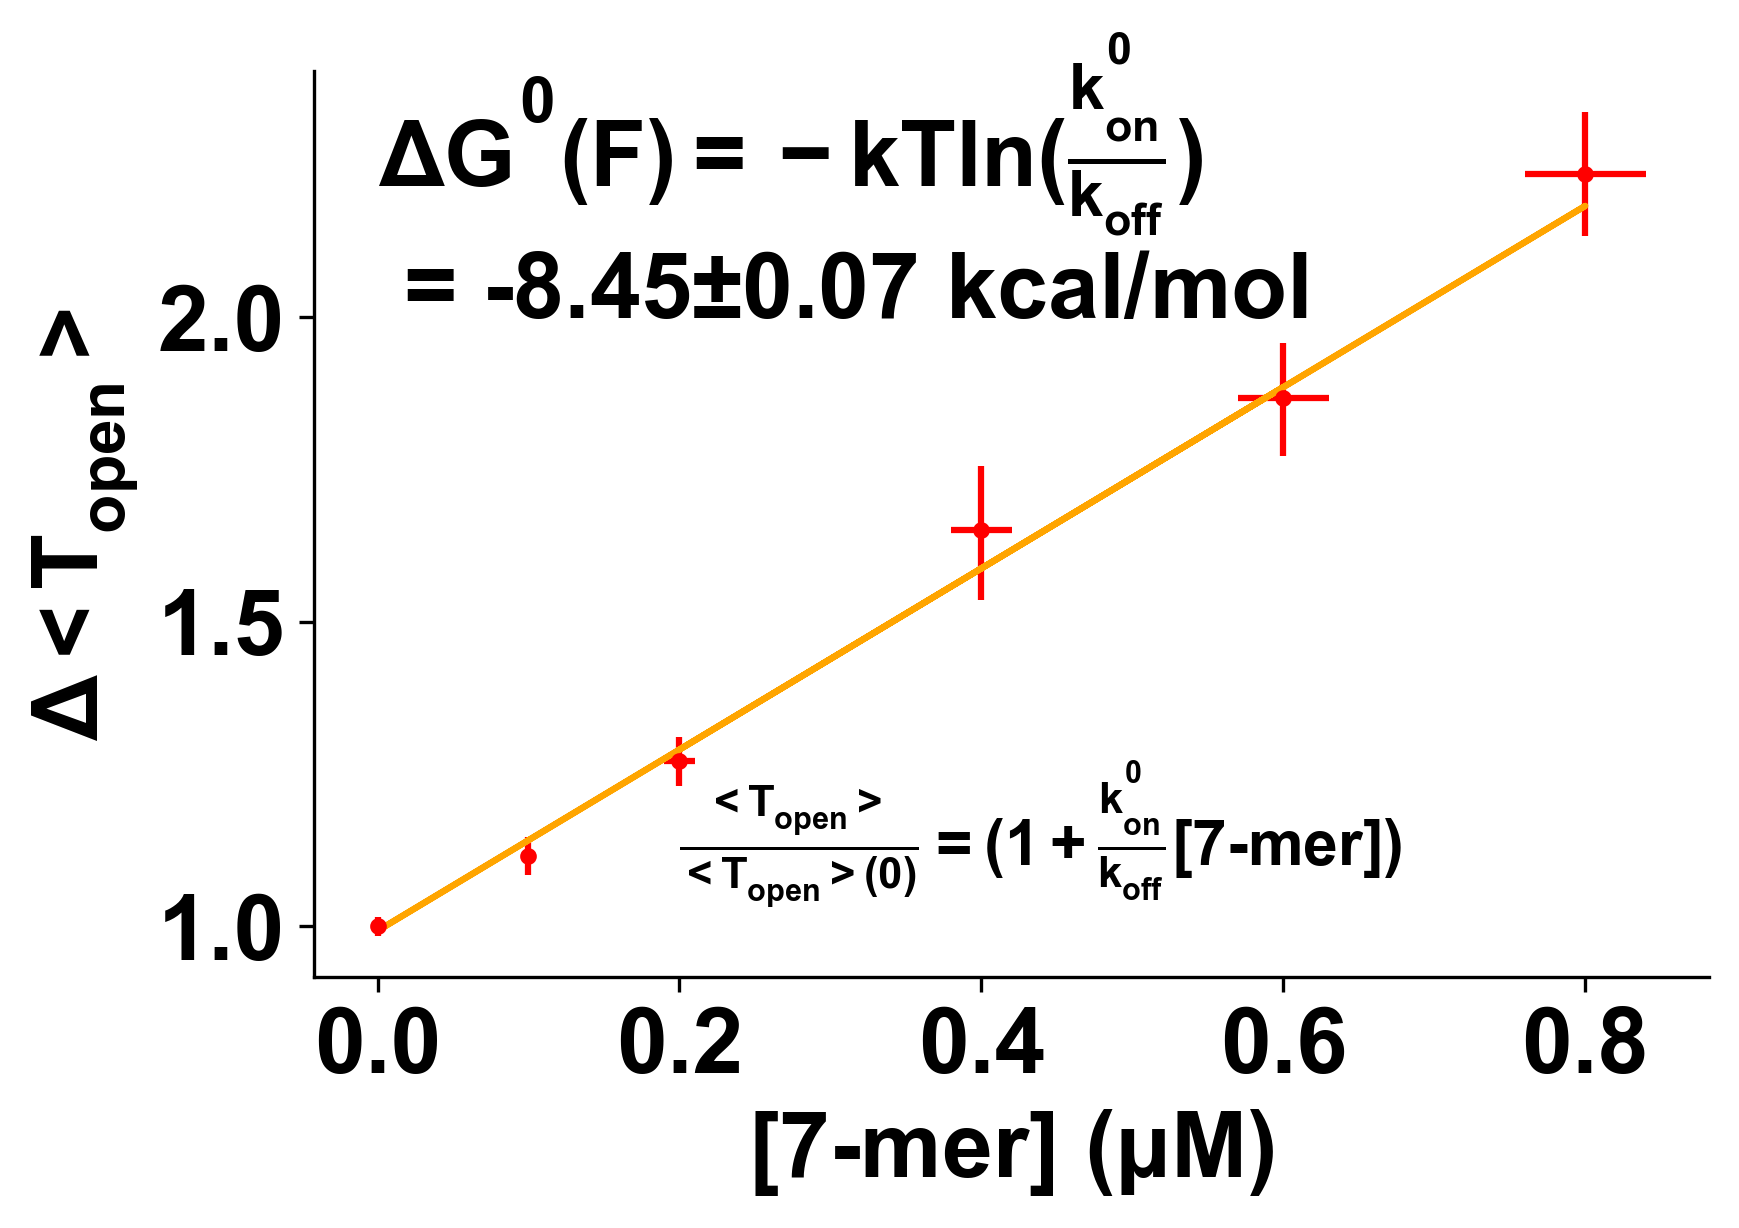

In [22]:
Oli7 = read_dir("2020_09_01/")
np.save("2020_09_01.npy",Oli7)

draw_open_state(Oli7,"7-mer",1,0.2,1.1,0,2.0)

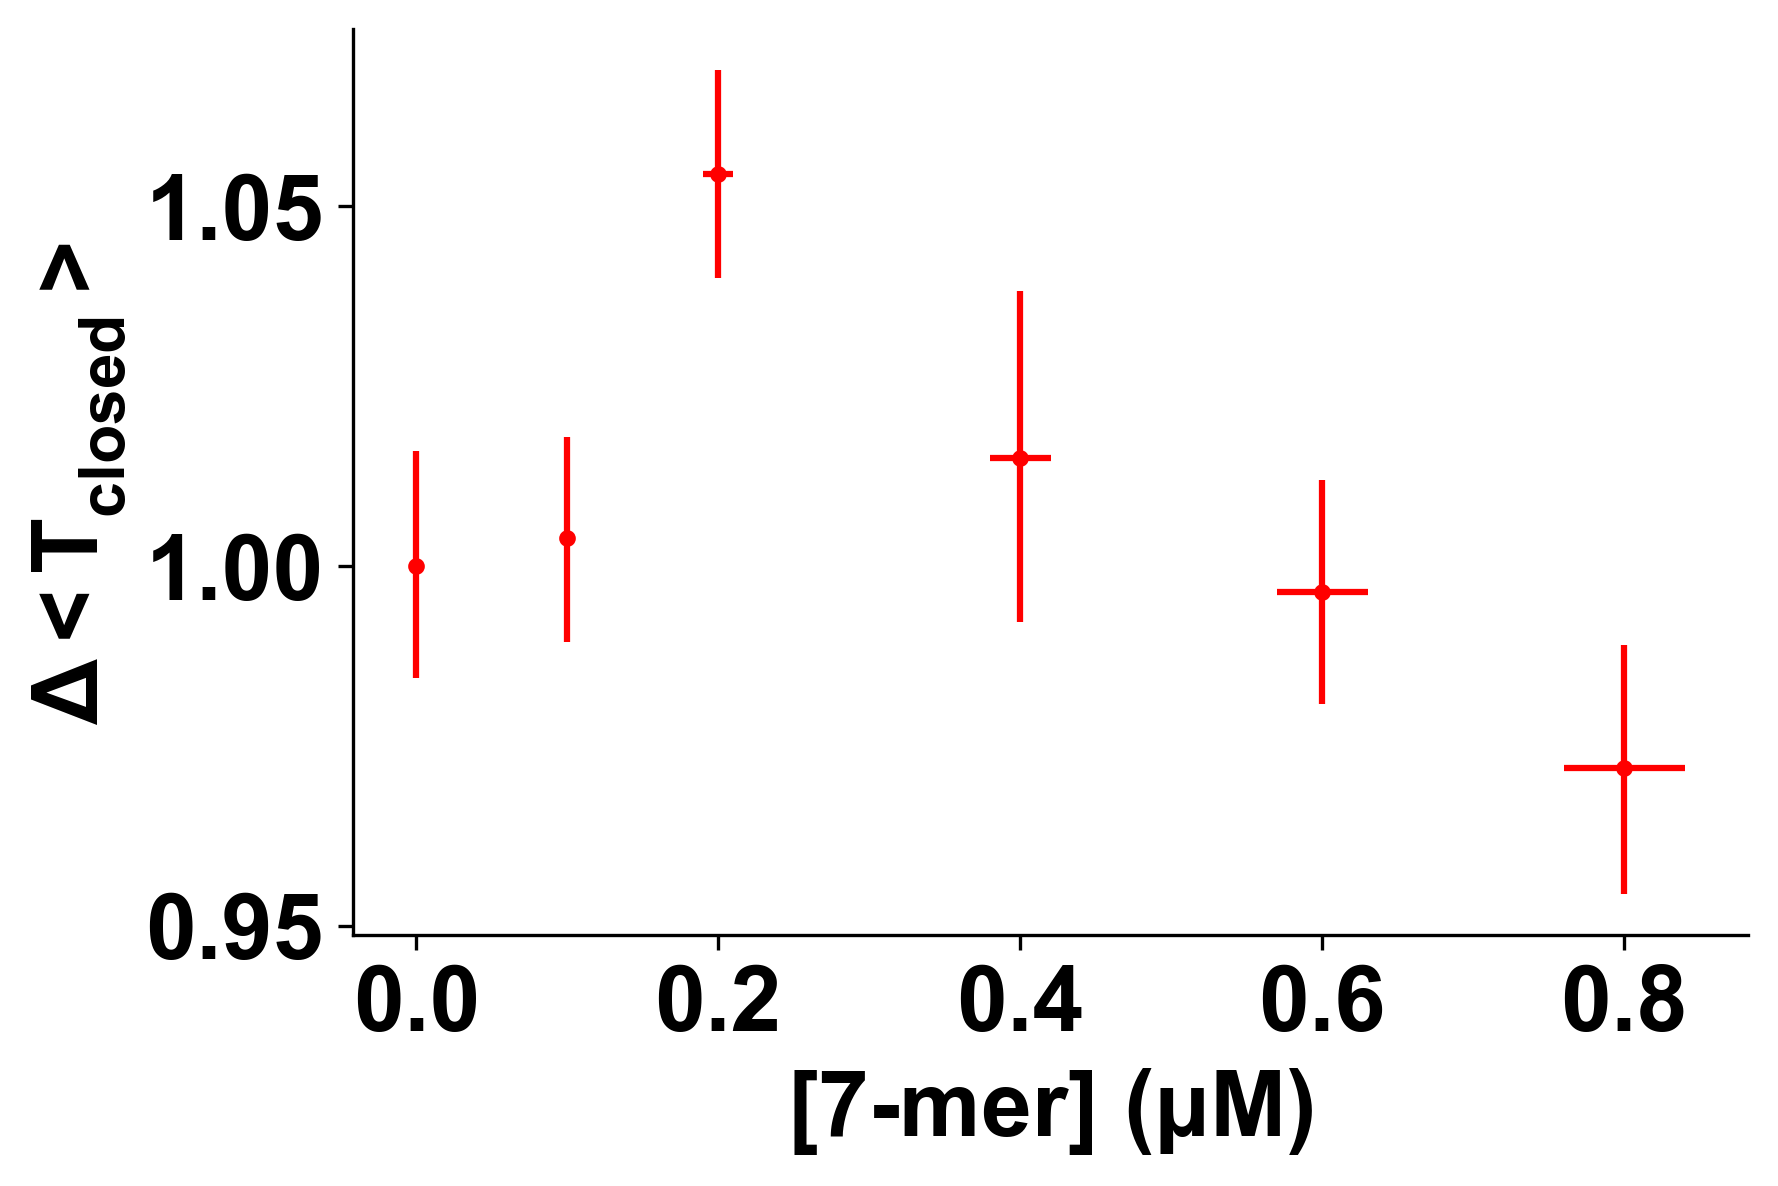

In [23]:
draw_close_state(Oli7,"7-mer",1)

Delta G = -4.23+- 0.05


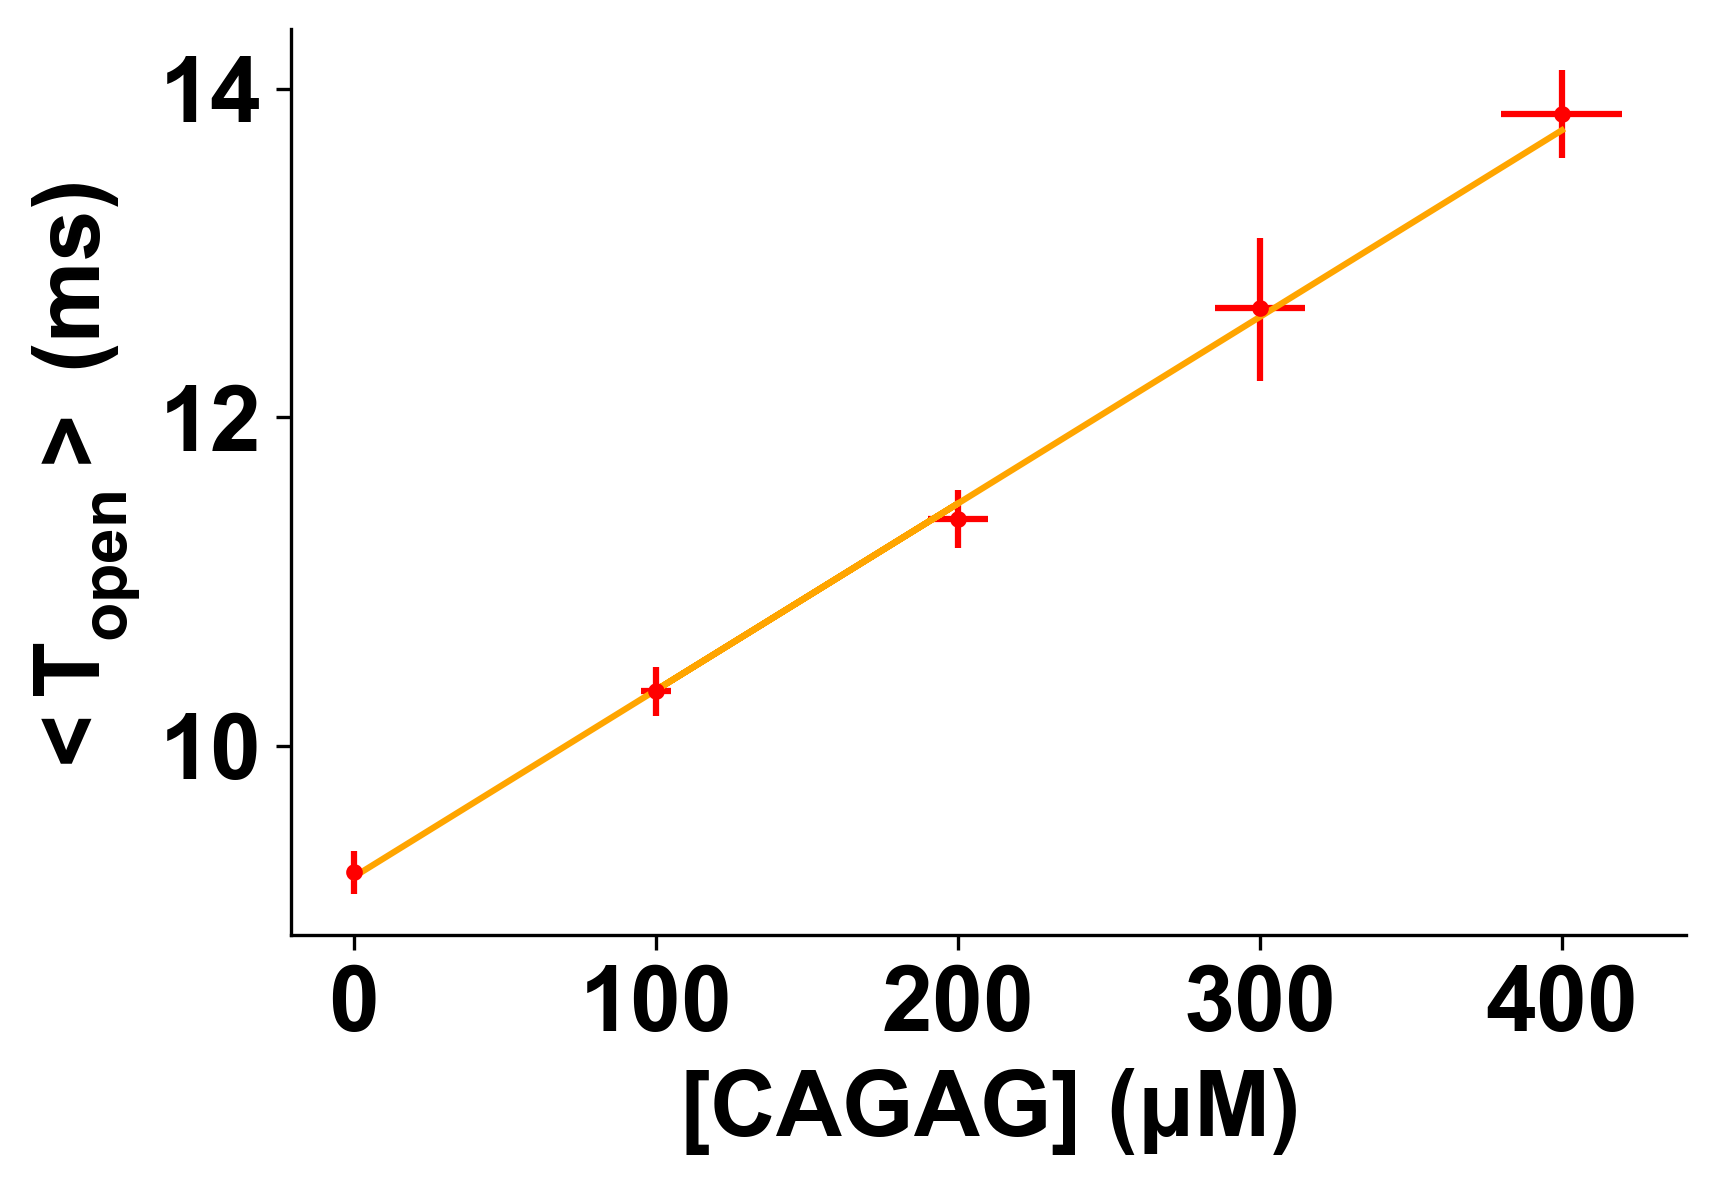

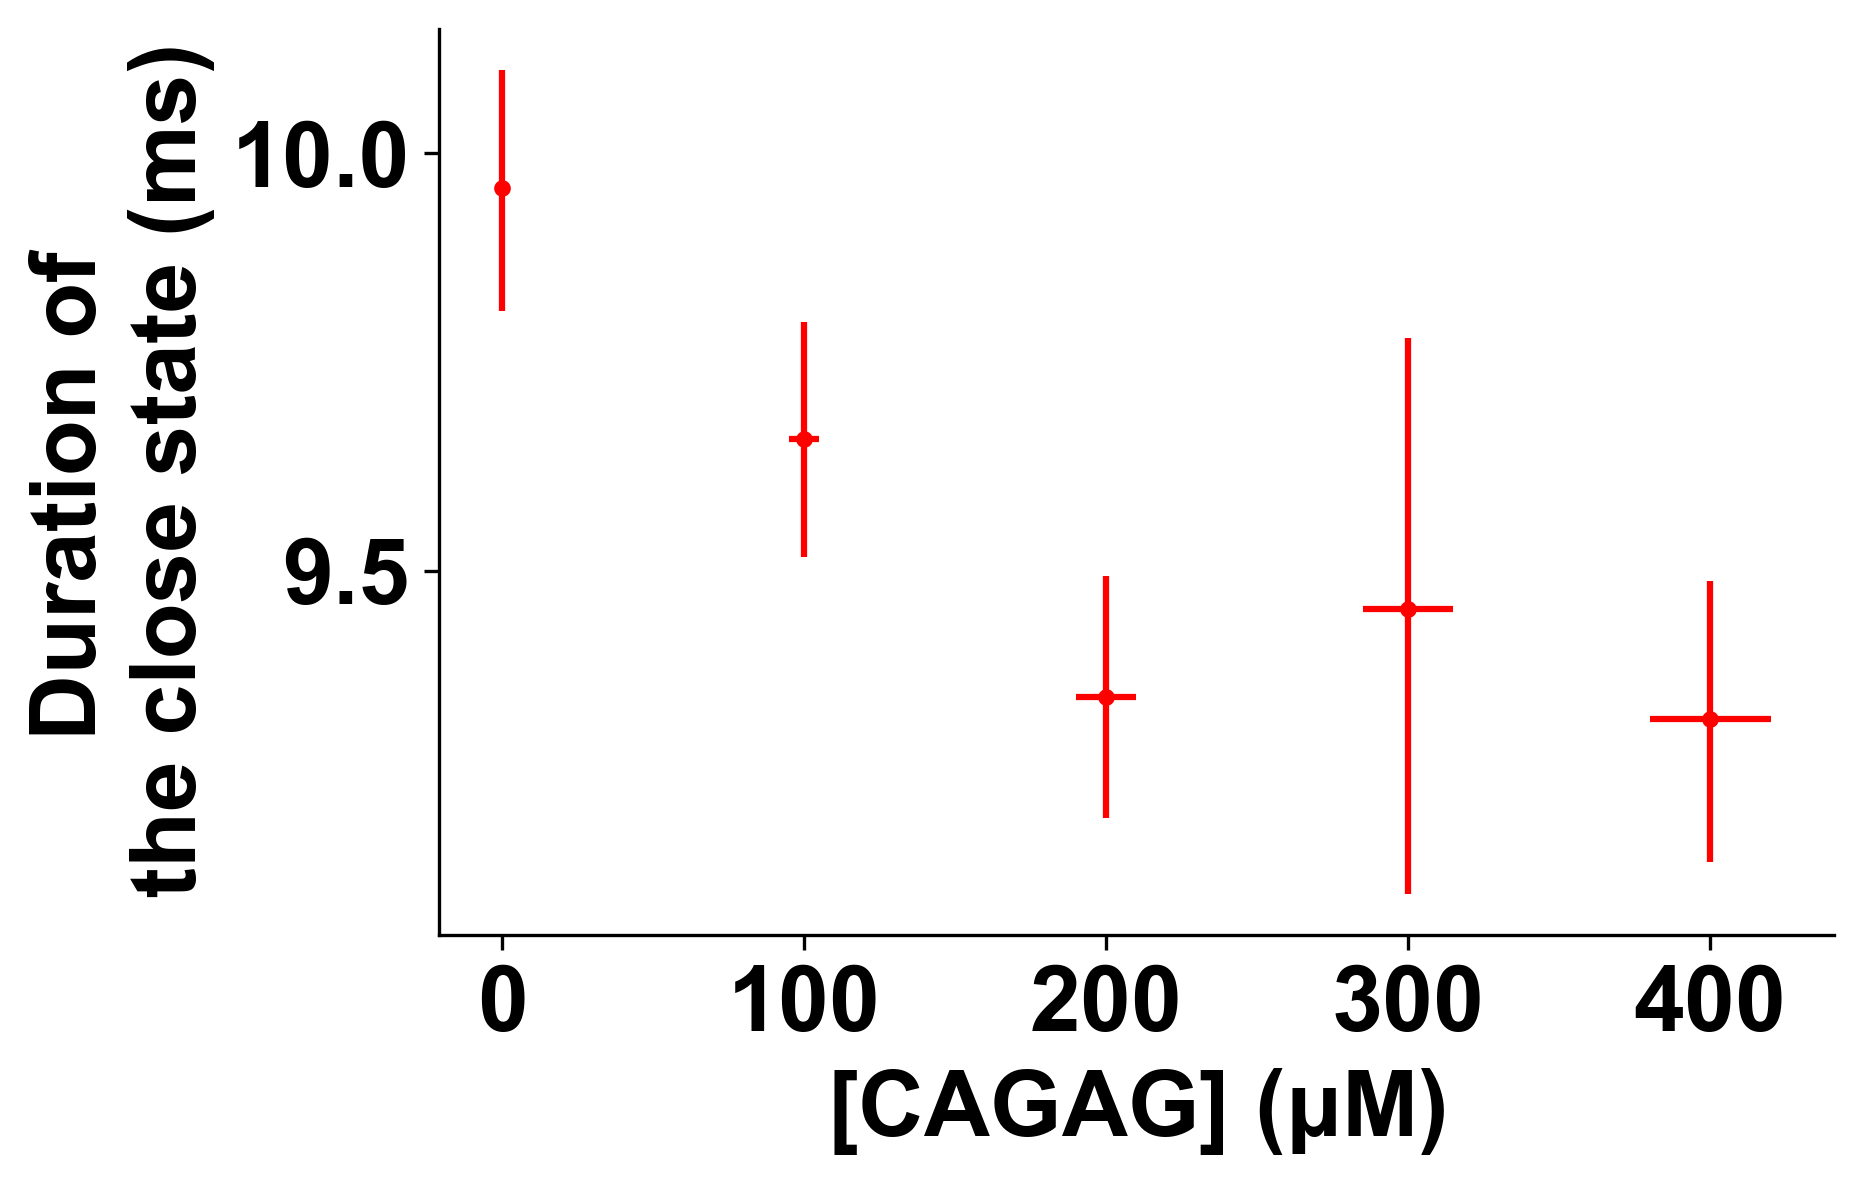

In [24]:
Oli5_2 = read_dir("2020_09_11_oli5/")
np.save("2020_09_11_oli5.npy",Oli5_2)
draw_open_state(Oli5_2,"CAGAG",0,-1,-1,-1,-1)
draw_close_state(Oli5_2,"CAGAG",0)

In [25]:
Oli5 = read_dir("2020_06_03/")


Delta G = -4.22+- 0.08


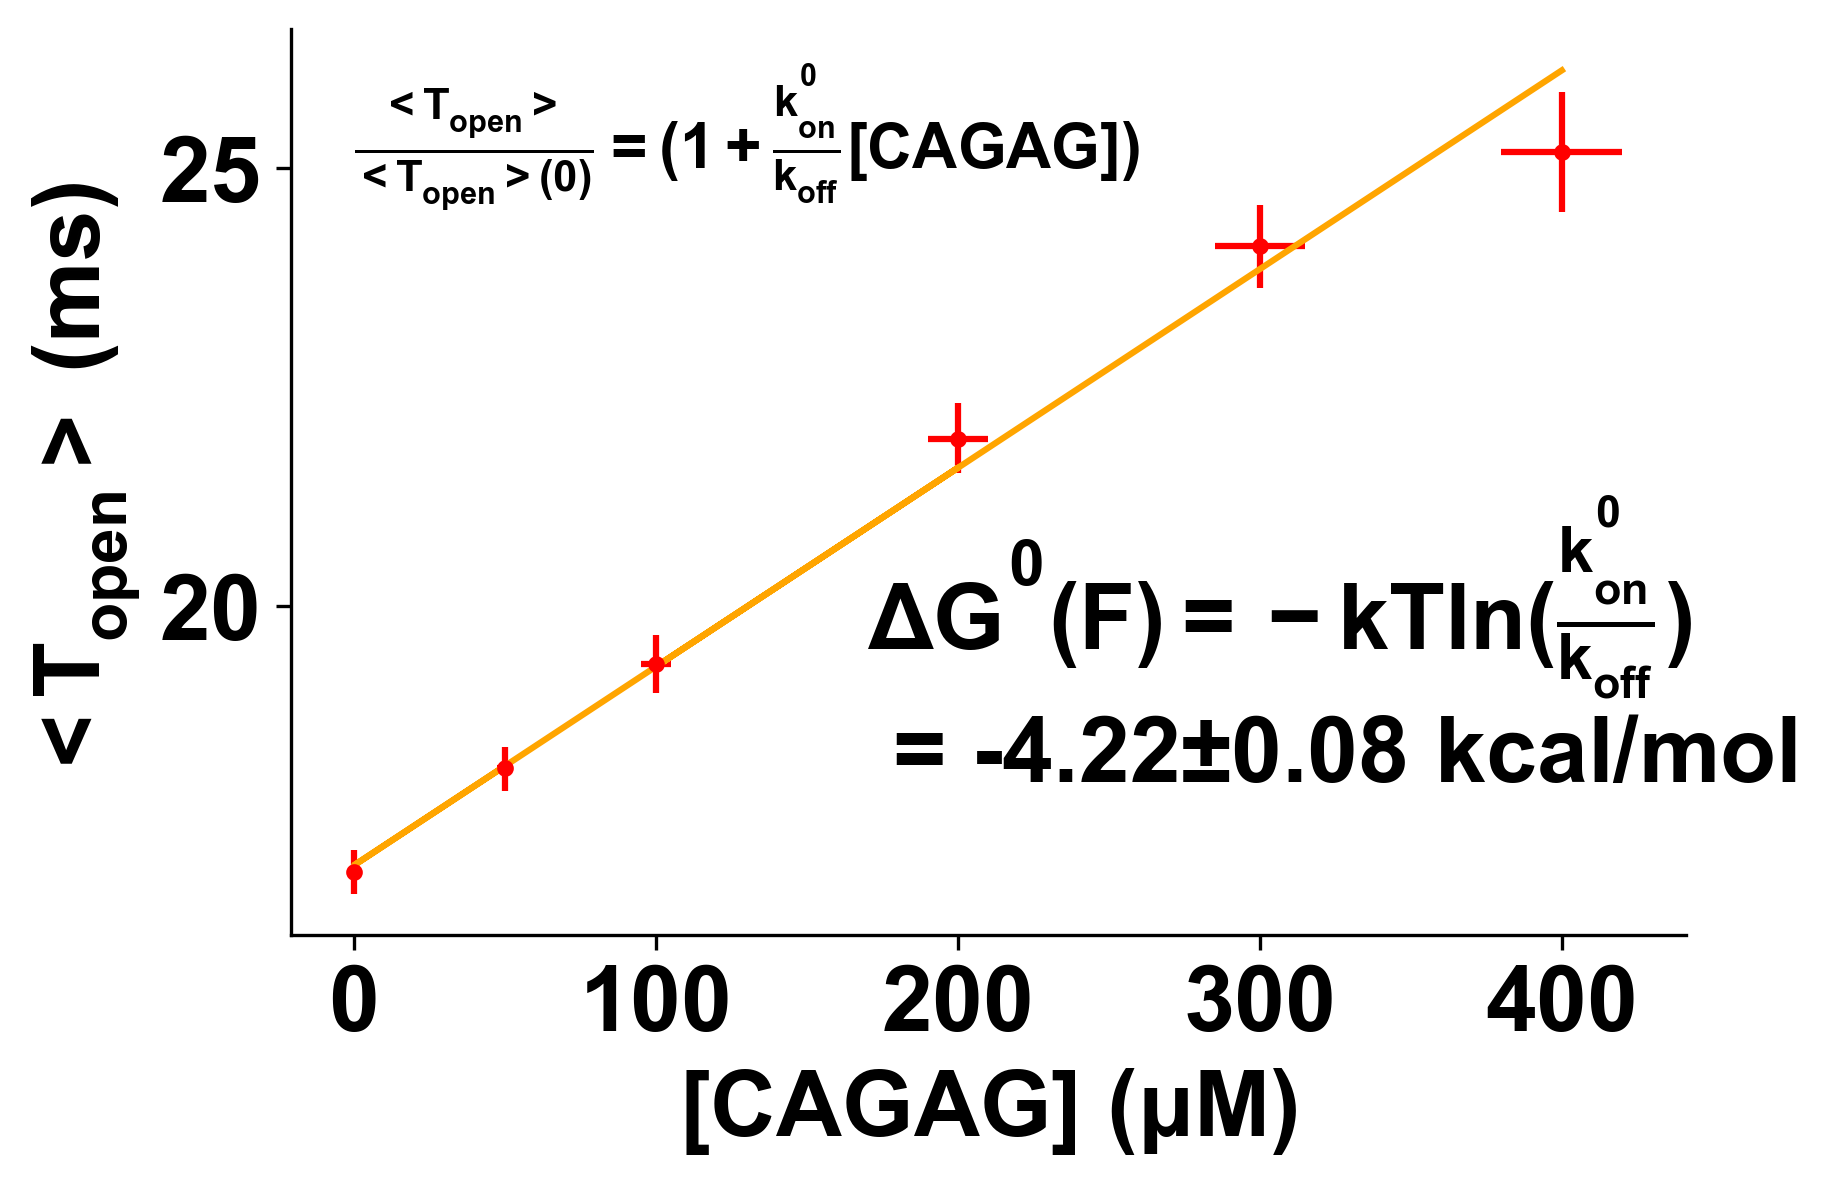

In [26]:
np.save("2020_06_03.npy",Oli5)
draw_open_state(Oli5,"CAGAG",0,0,25,170,18)

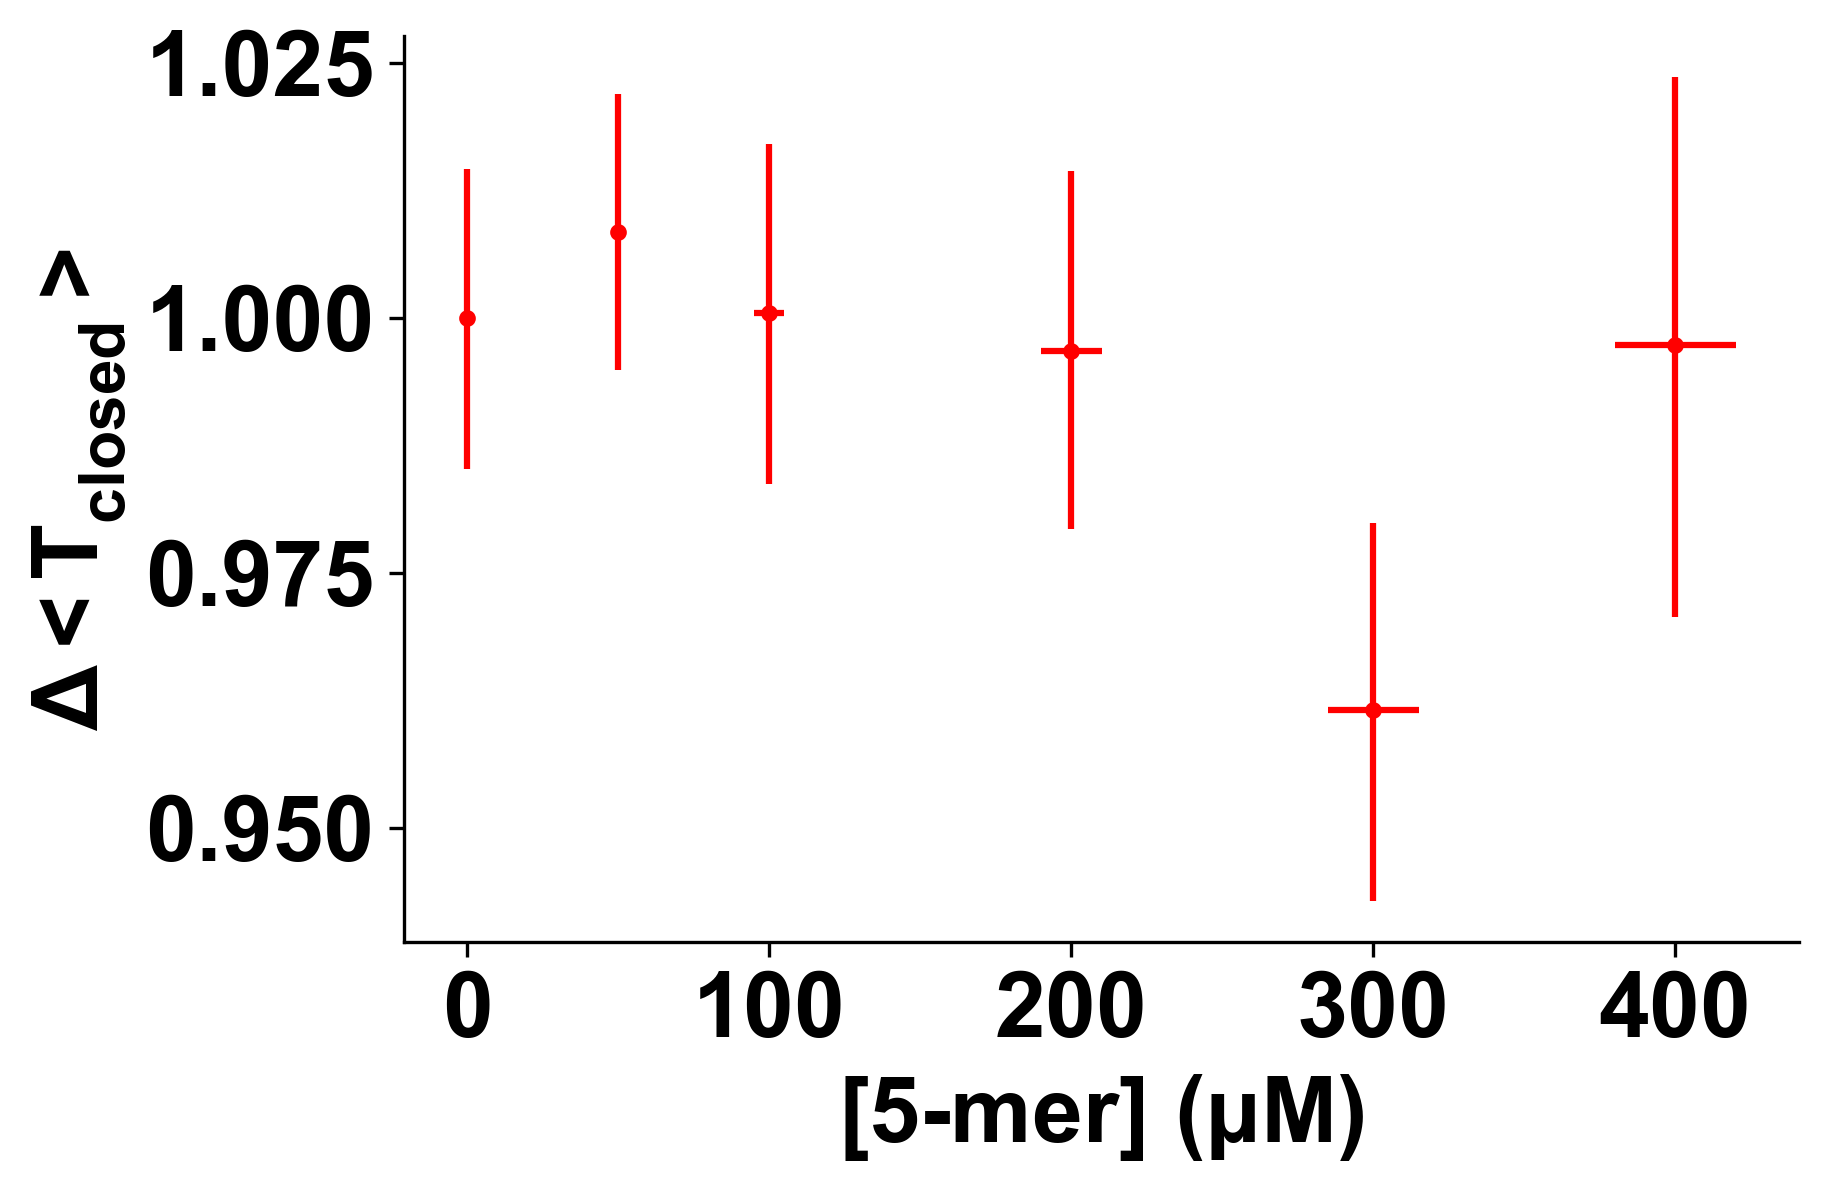

In [27]:
draw_close_state(Oli5,"5-mer",1)

Bead _0 _ oligo_5_mutated


In [28]:
Oli5mut = read_dir("2020_06_15/")


Delta G = -1.53+- 3.65


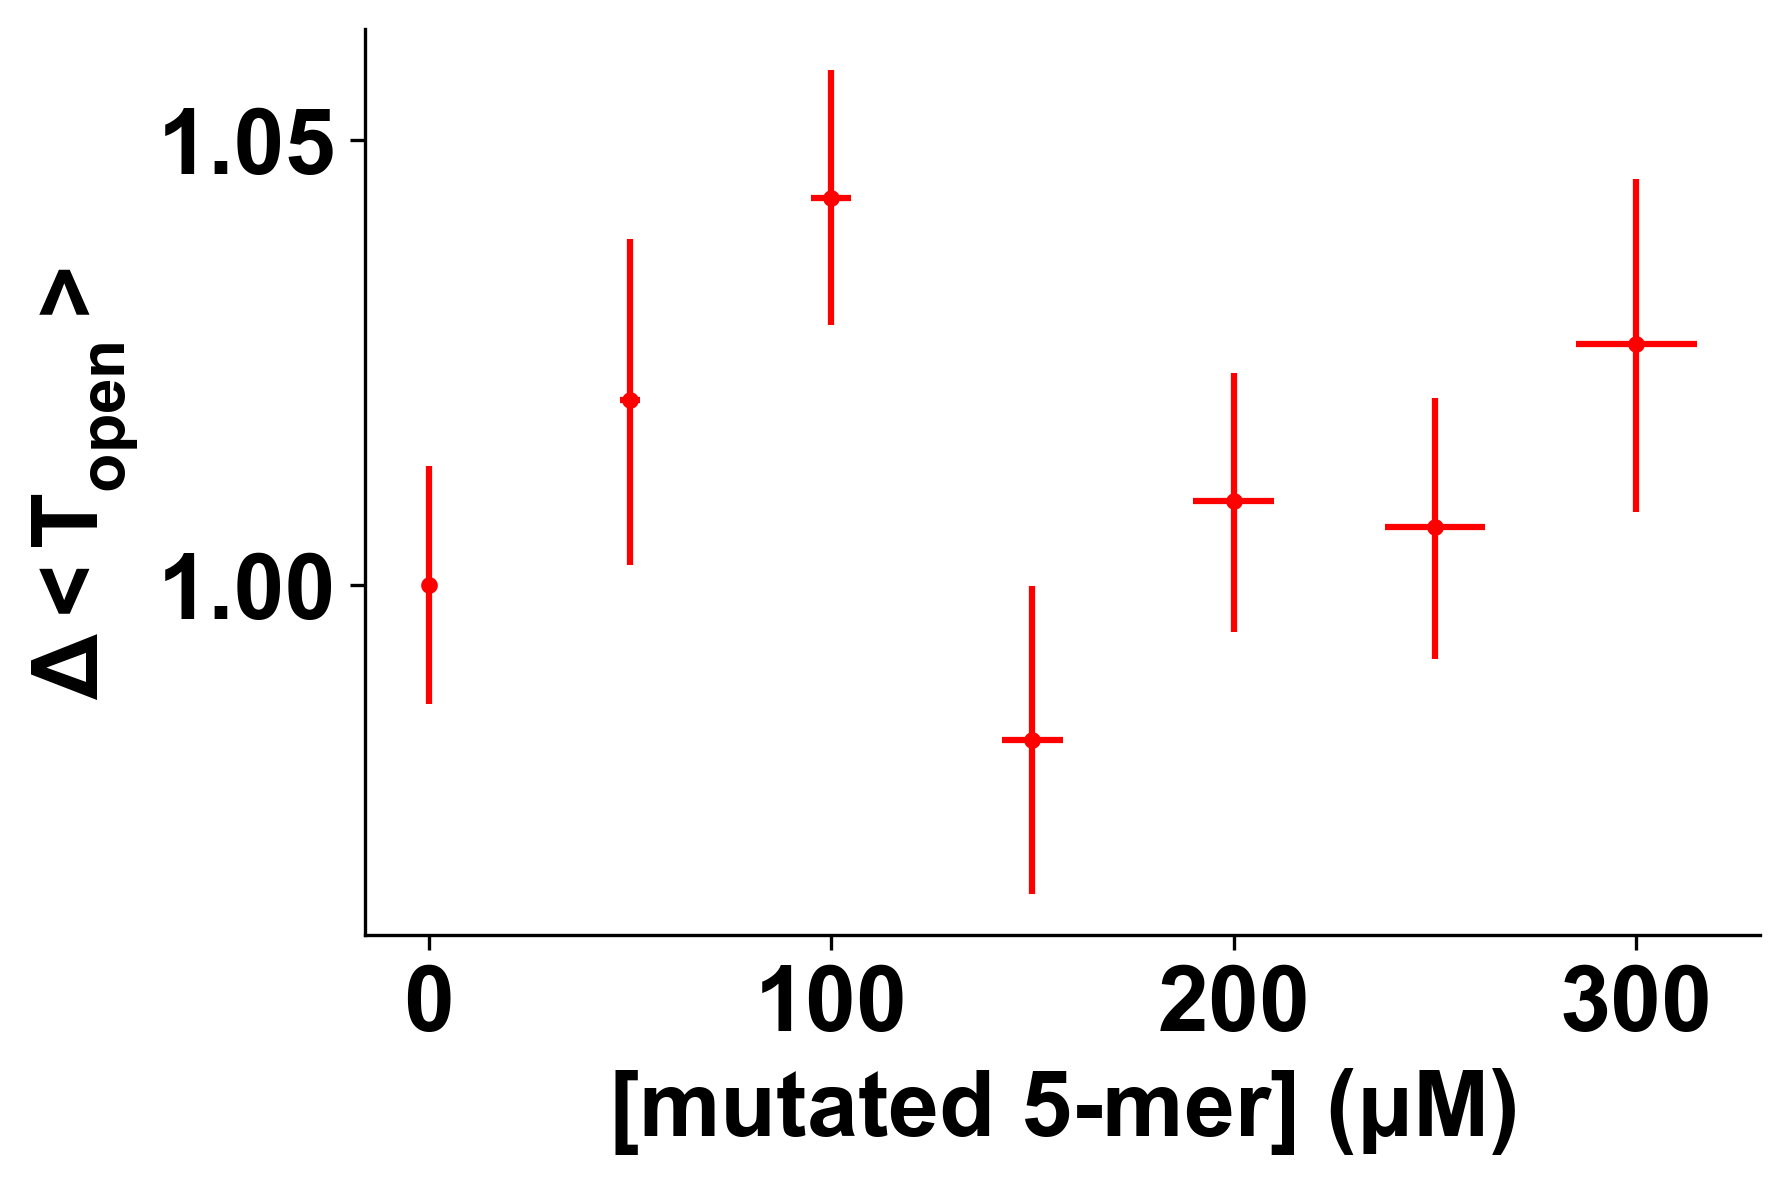

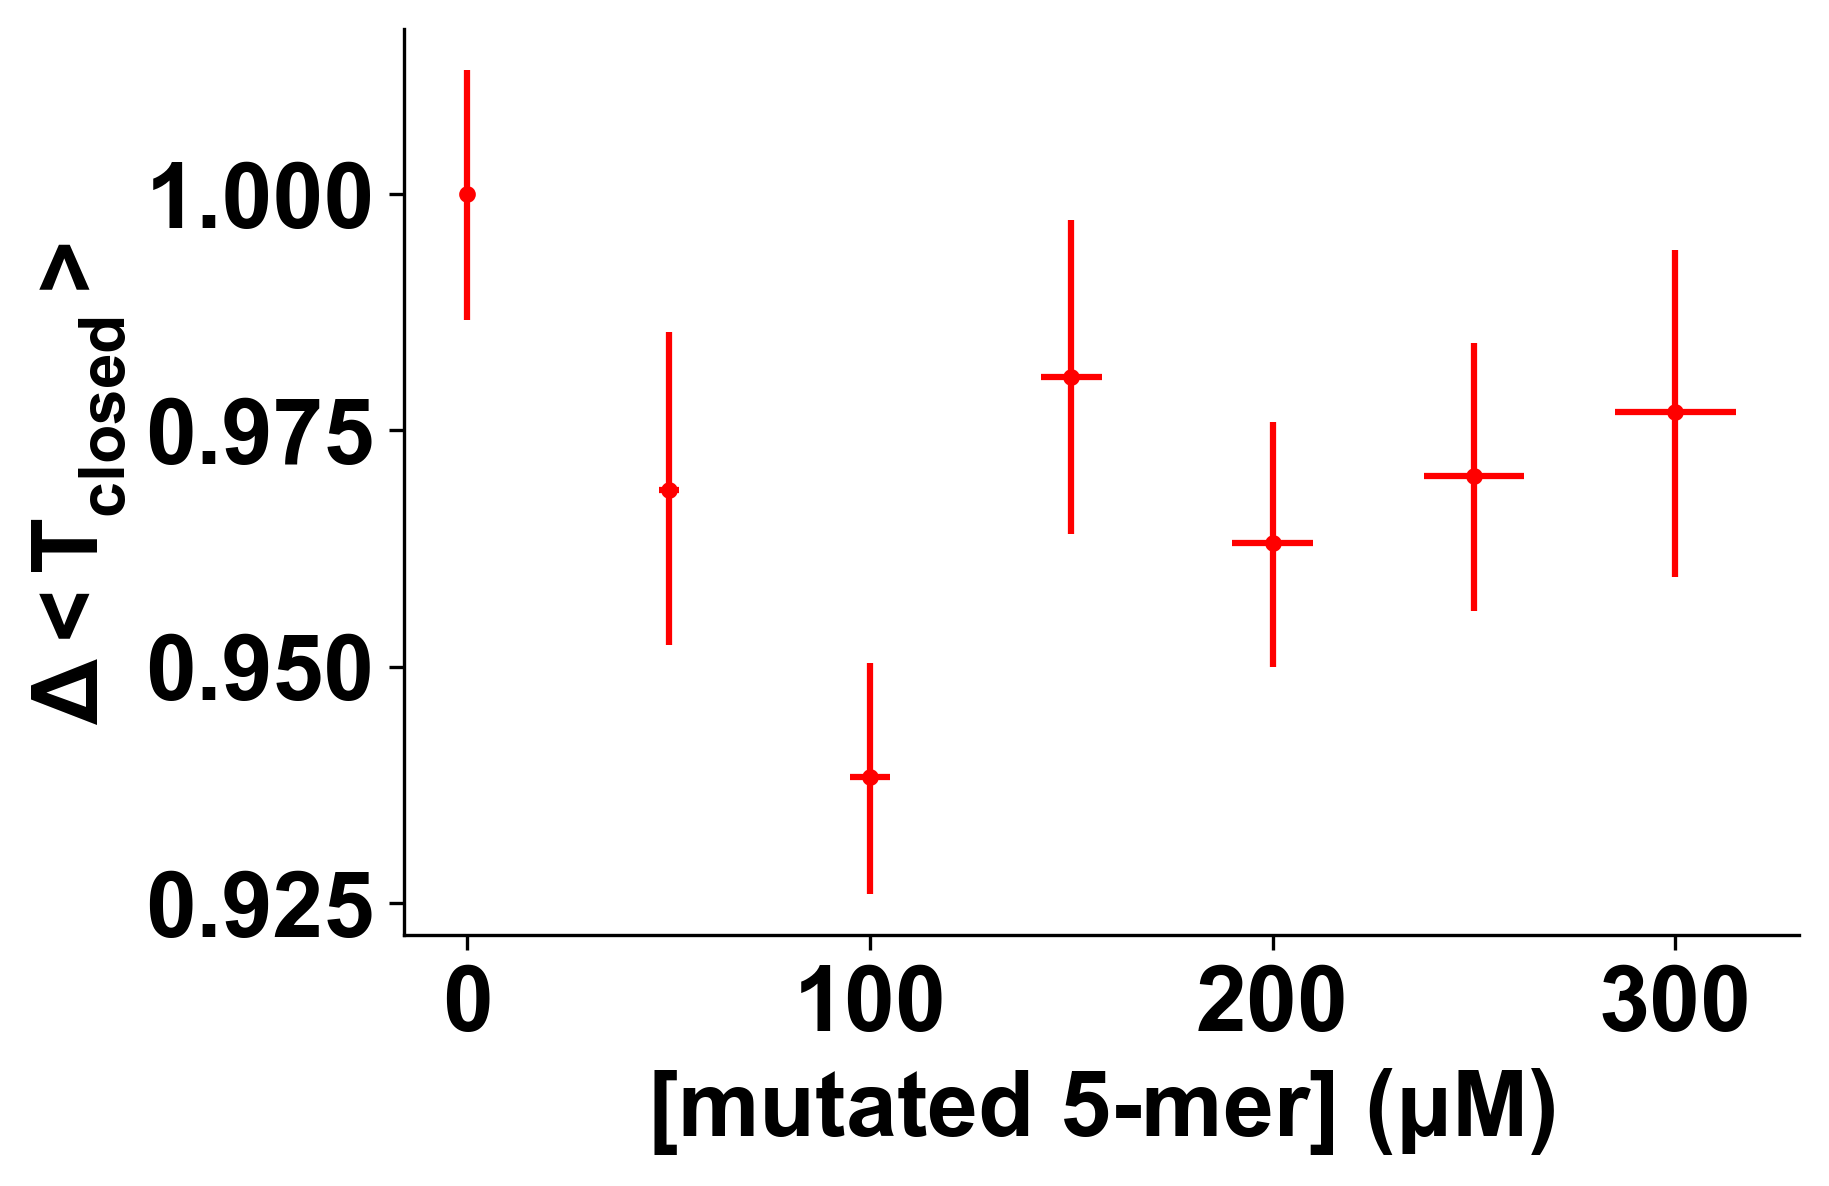

In [29]:
np.save("2020_06_15.npy",Oli5mut)

draw_open_state(Oli5mut,"mutated 5-mer",1,nofit=1)
draw_close_state(Oli5mut,"mutated 5-mer",1)

Bead 0 10/06 : oligo 6 

In [30]:
Oli6 = read_dir("2020_06_10_Bd0/")



Delta G = -6.0+- 0.09


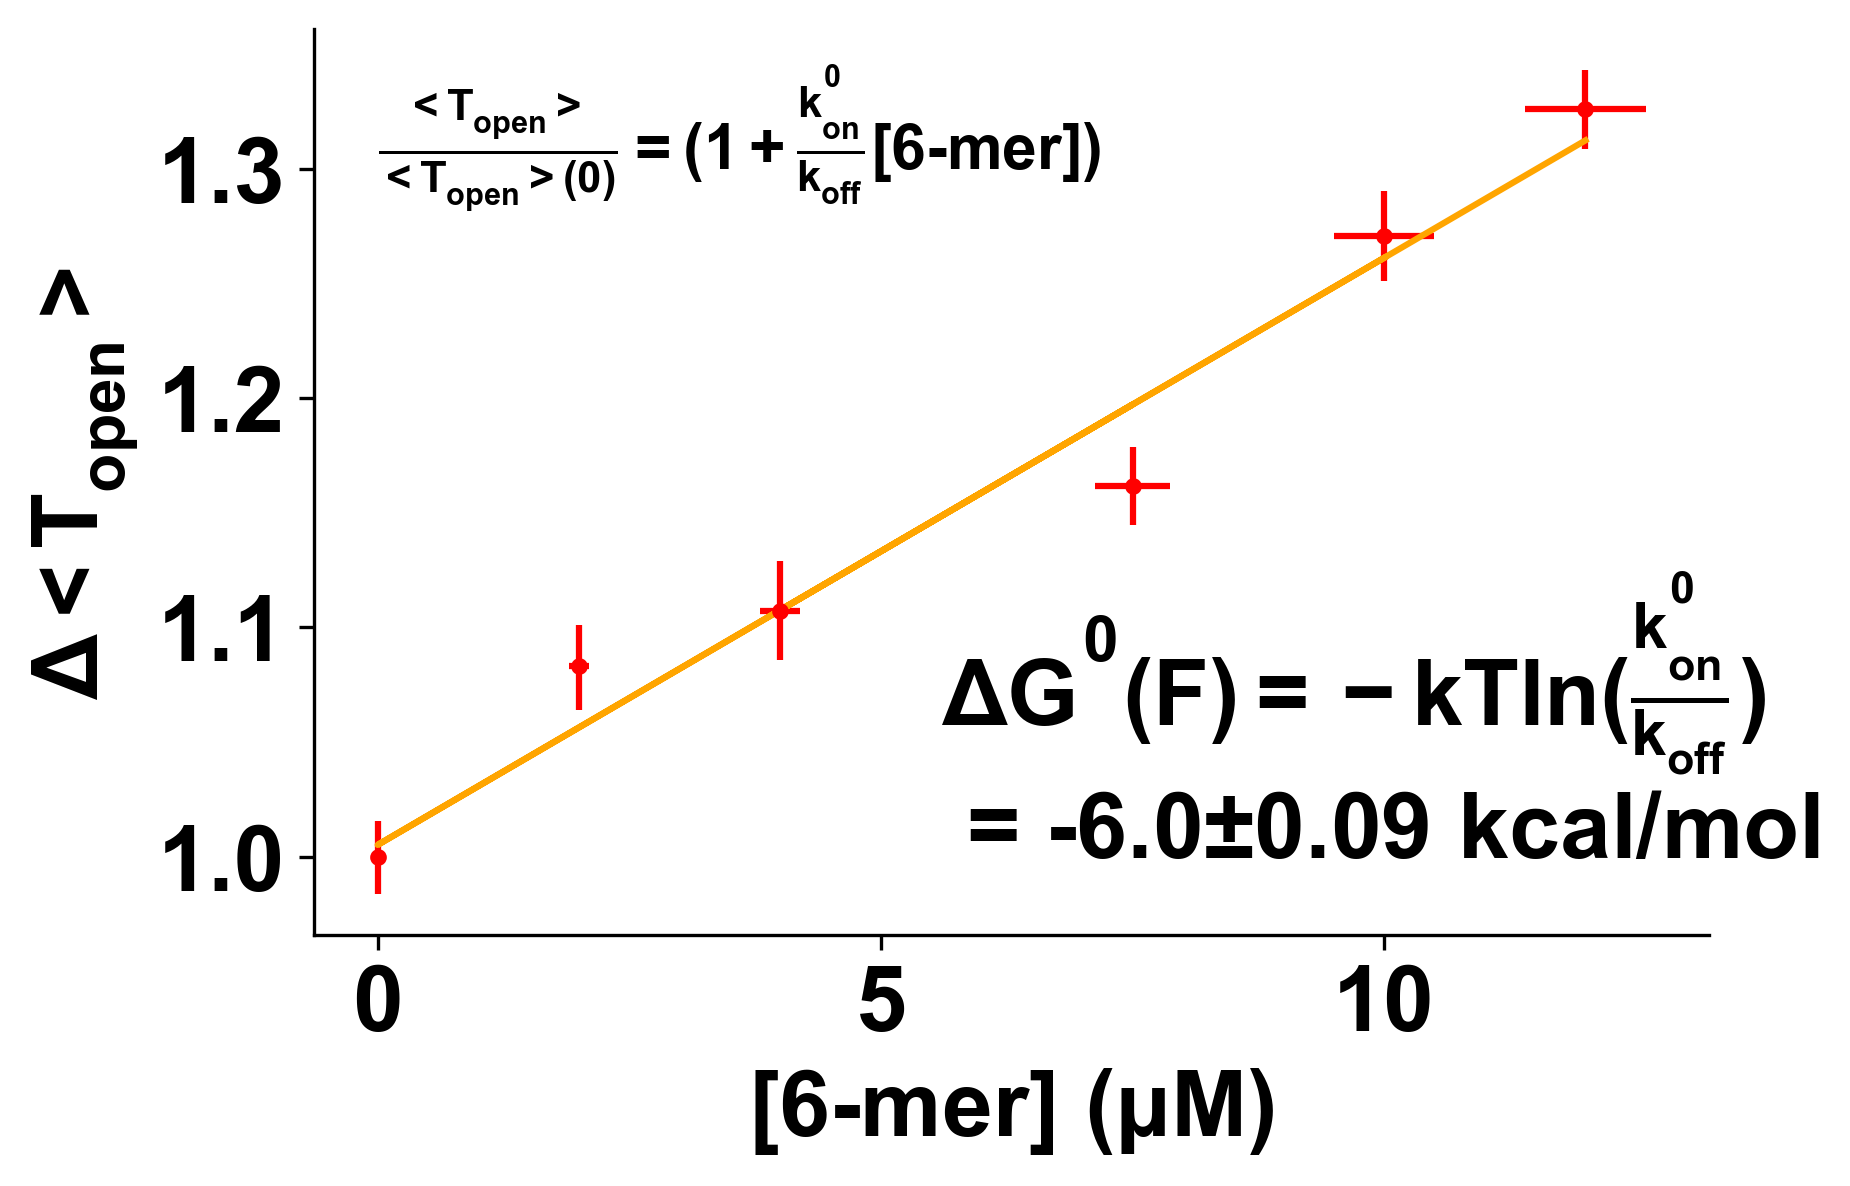

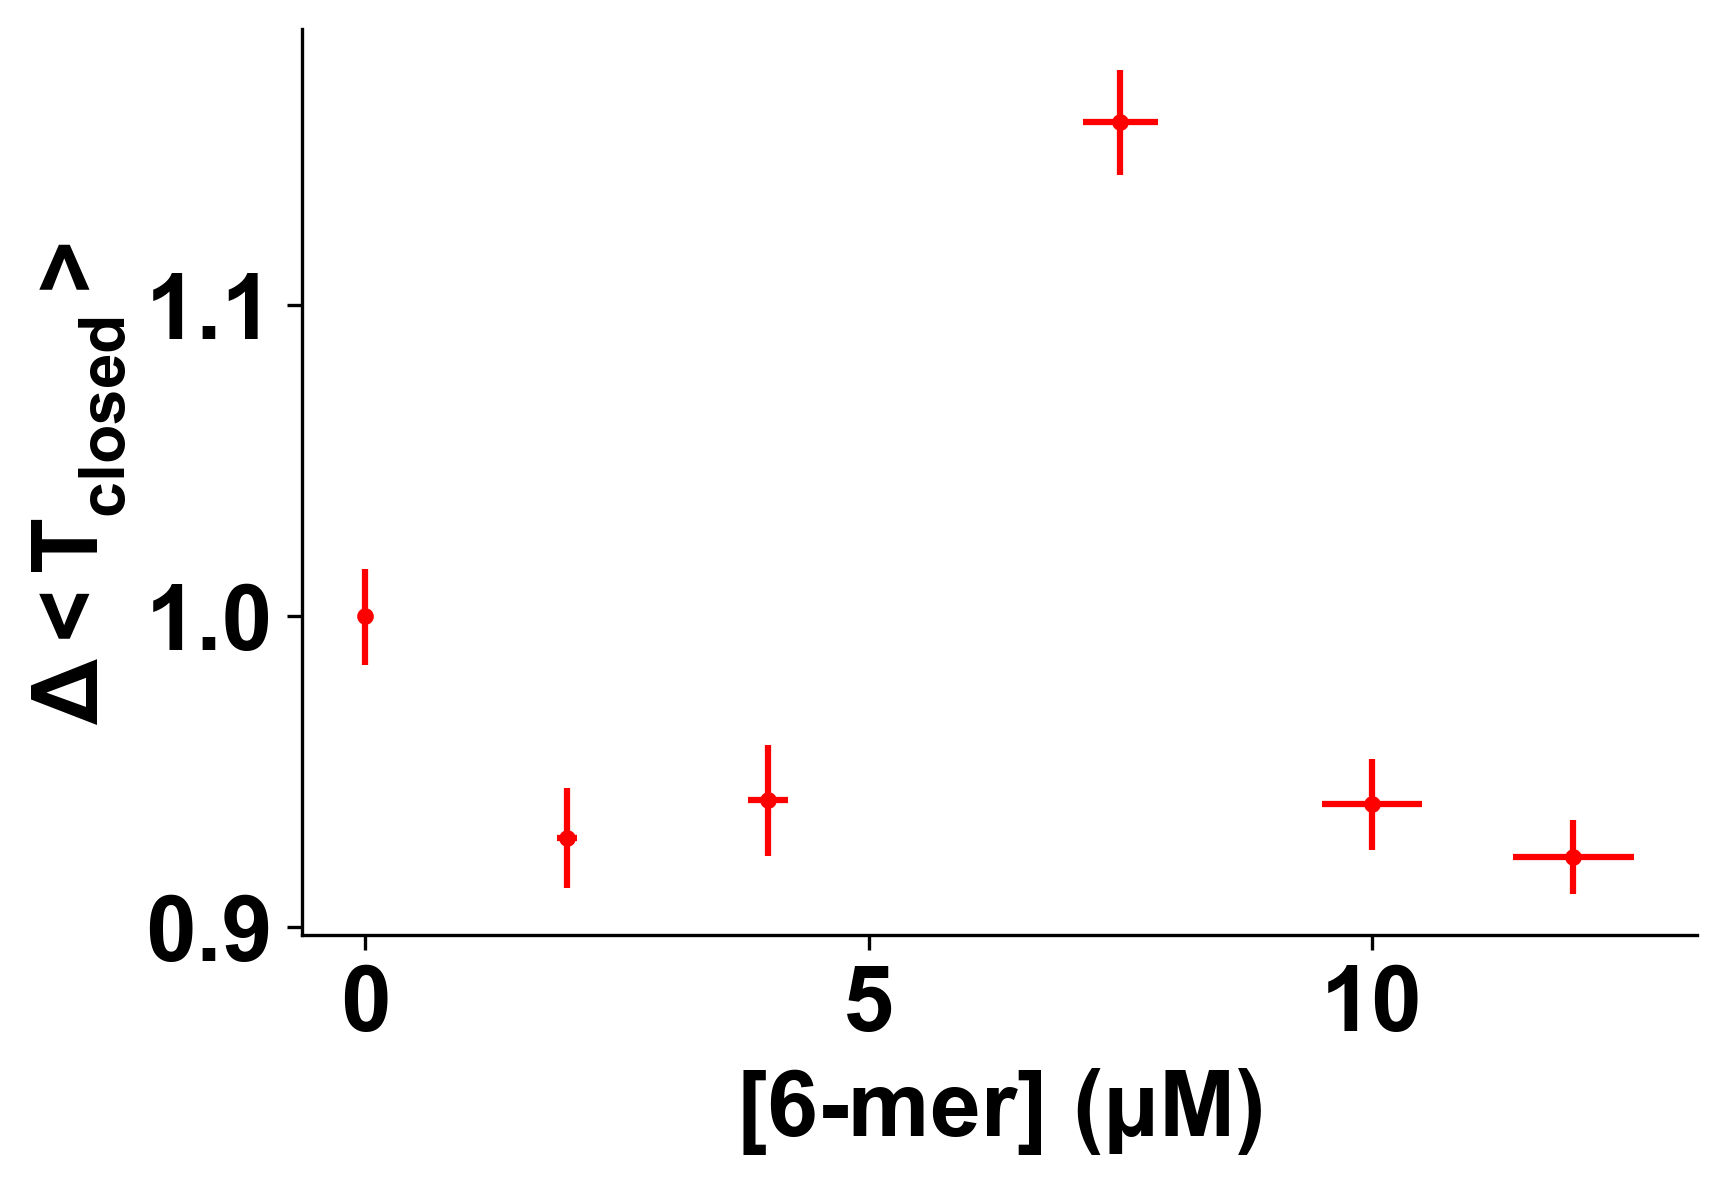

In [31]:
np.save("2020_06_10_Bd0.npy",Oli6)

Oli6[0][2] = 7.5
draw_open_state(Oli6,"6-mer",1,0,1.3,5.6,1)
draw_close_state(Oli6,"6-mer",1)

In [32]:
Oliacr_1 = read_dir("2020_06_18_Bd0/")


Delta G = -7.33+- 0.05


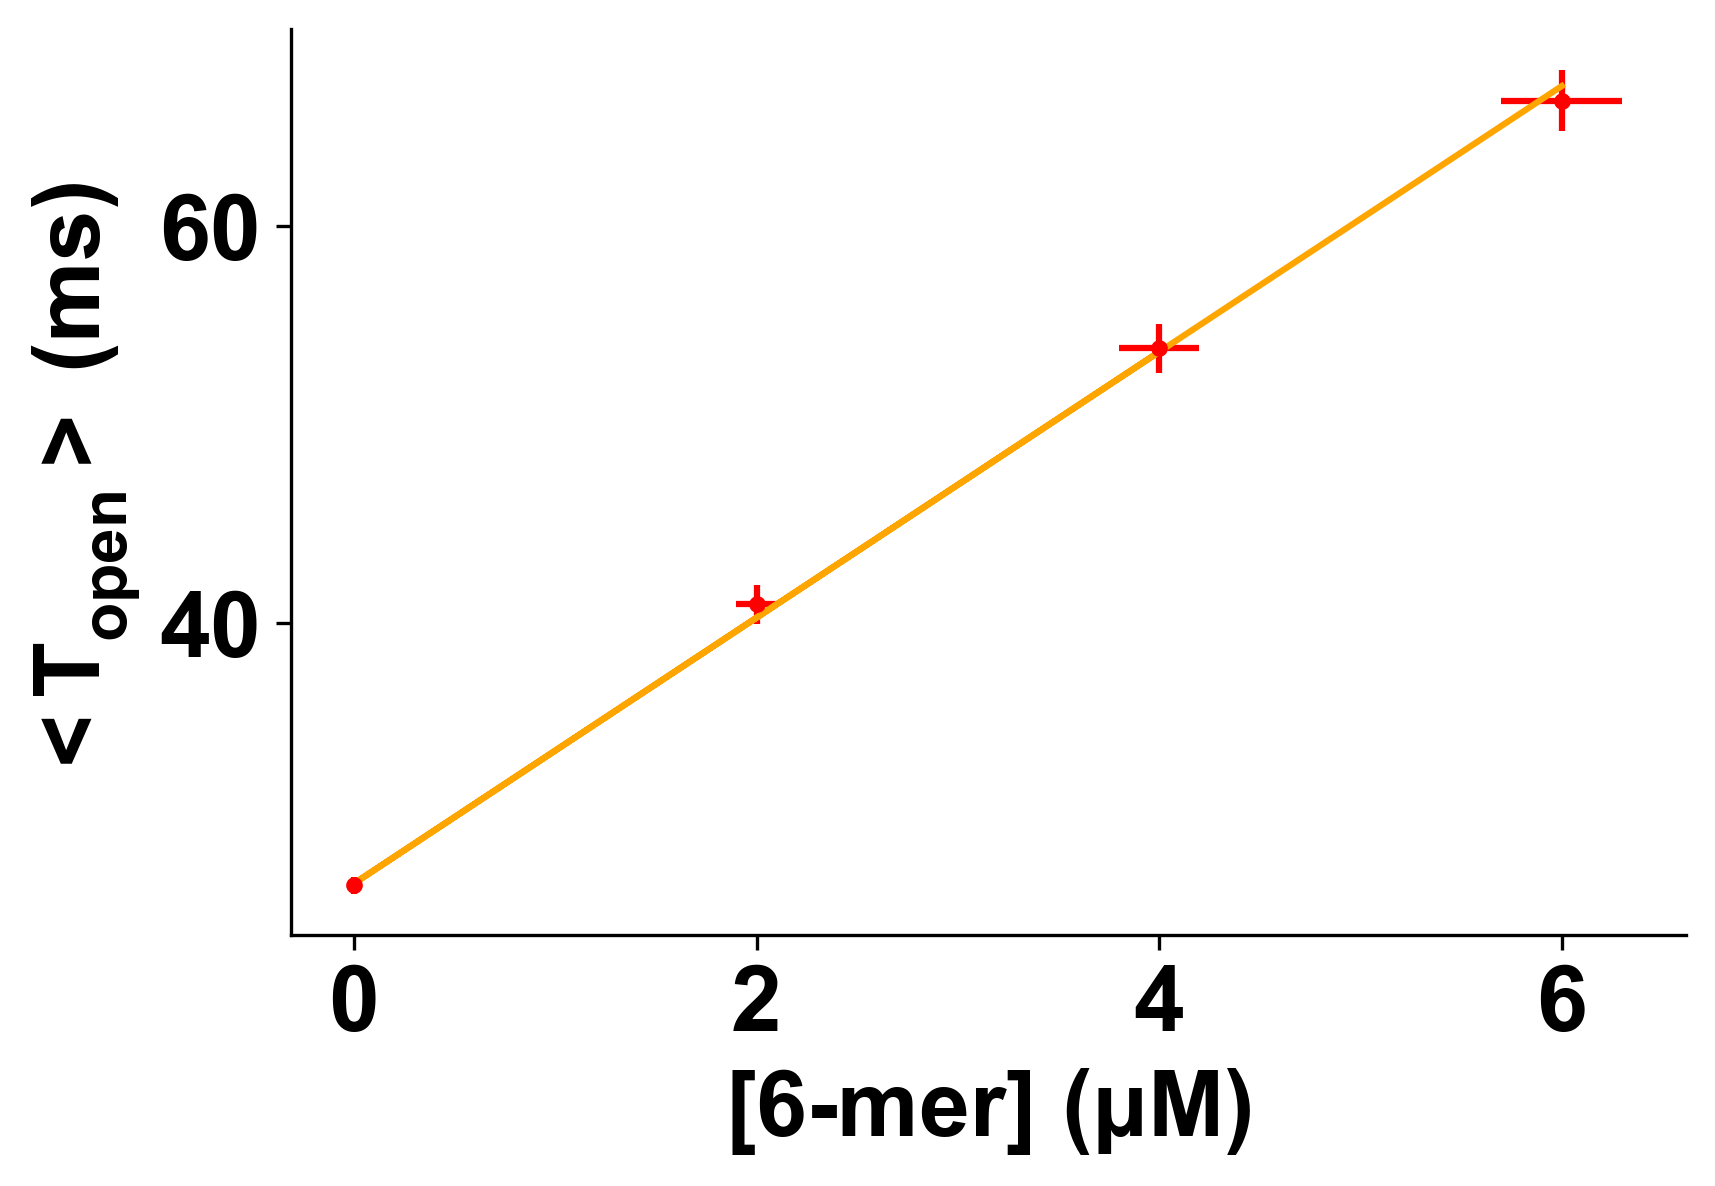

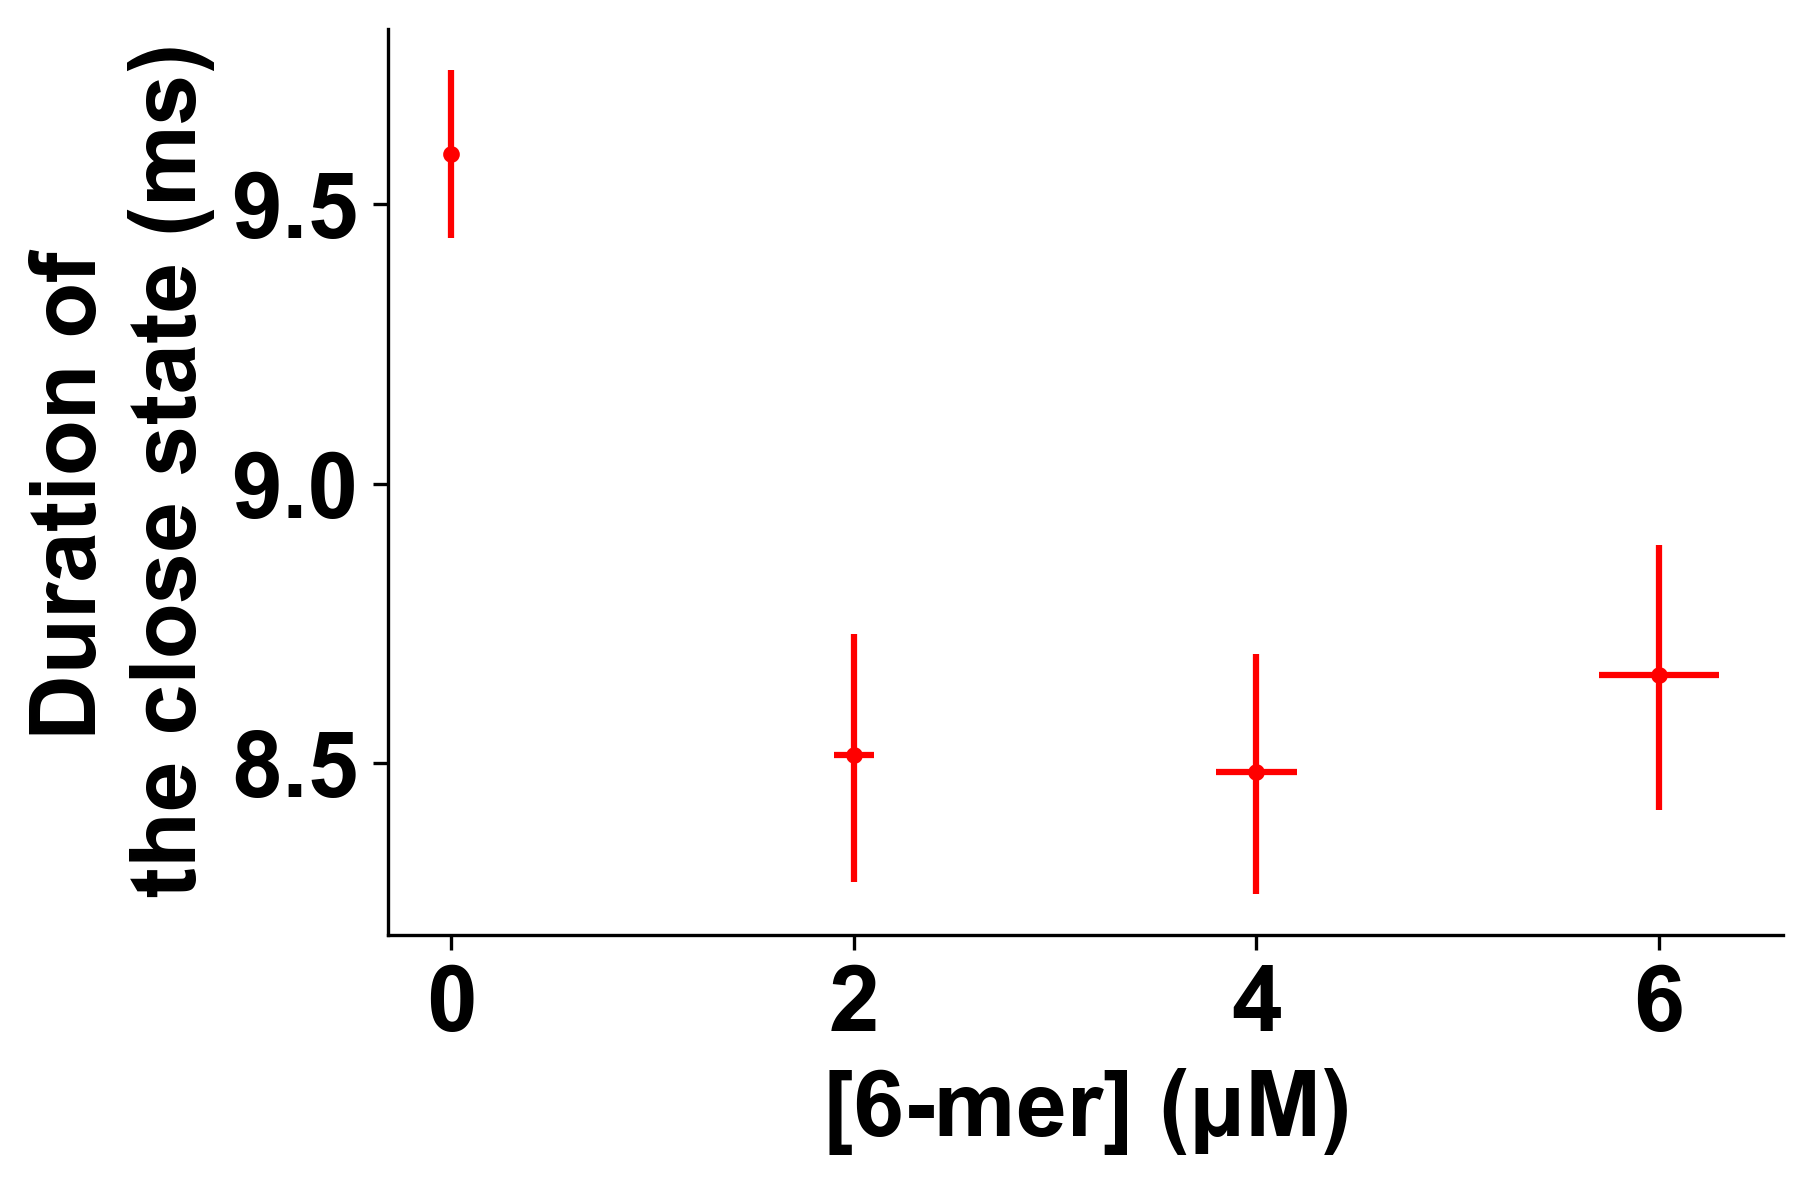

In [33]:
np.save("2020_06_18_Bd0.npy",Oliacr_1)

draw_open_state(Oliacr_1,"6-mer")
draw_close_state(Oliacr_1,"6-mer")

In [34]:
Oliacr_2 = read_dir("2020_06_18_Bd1/")


Delta G = -7.3+- 0.06


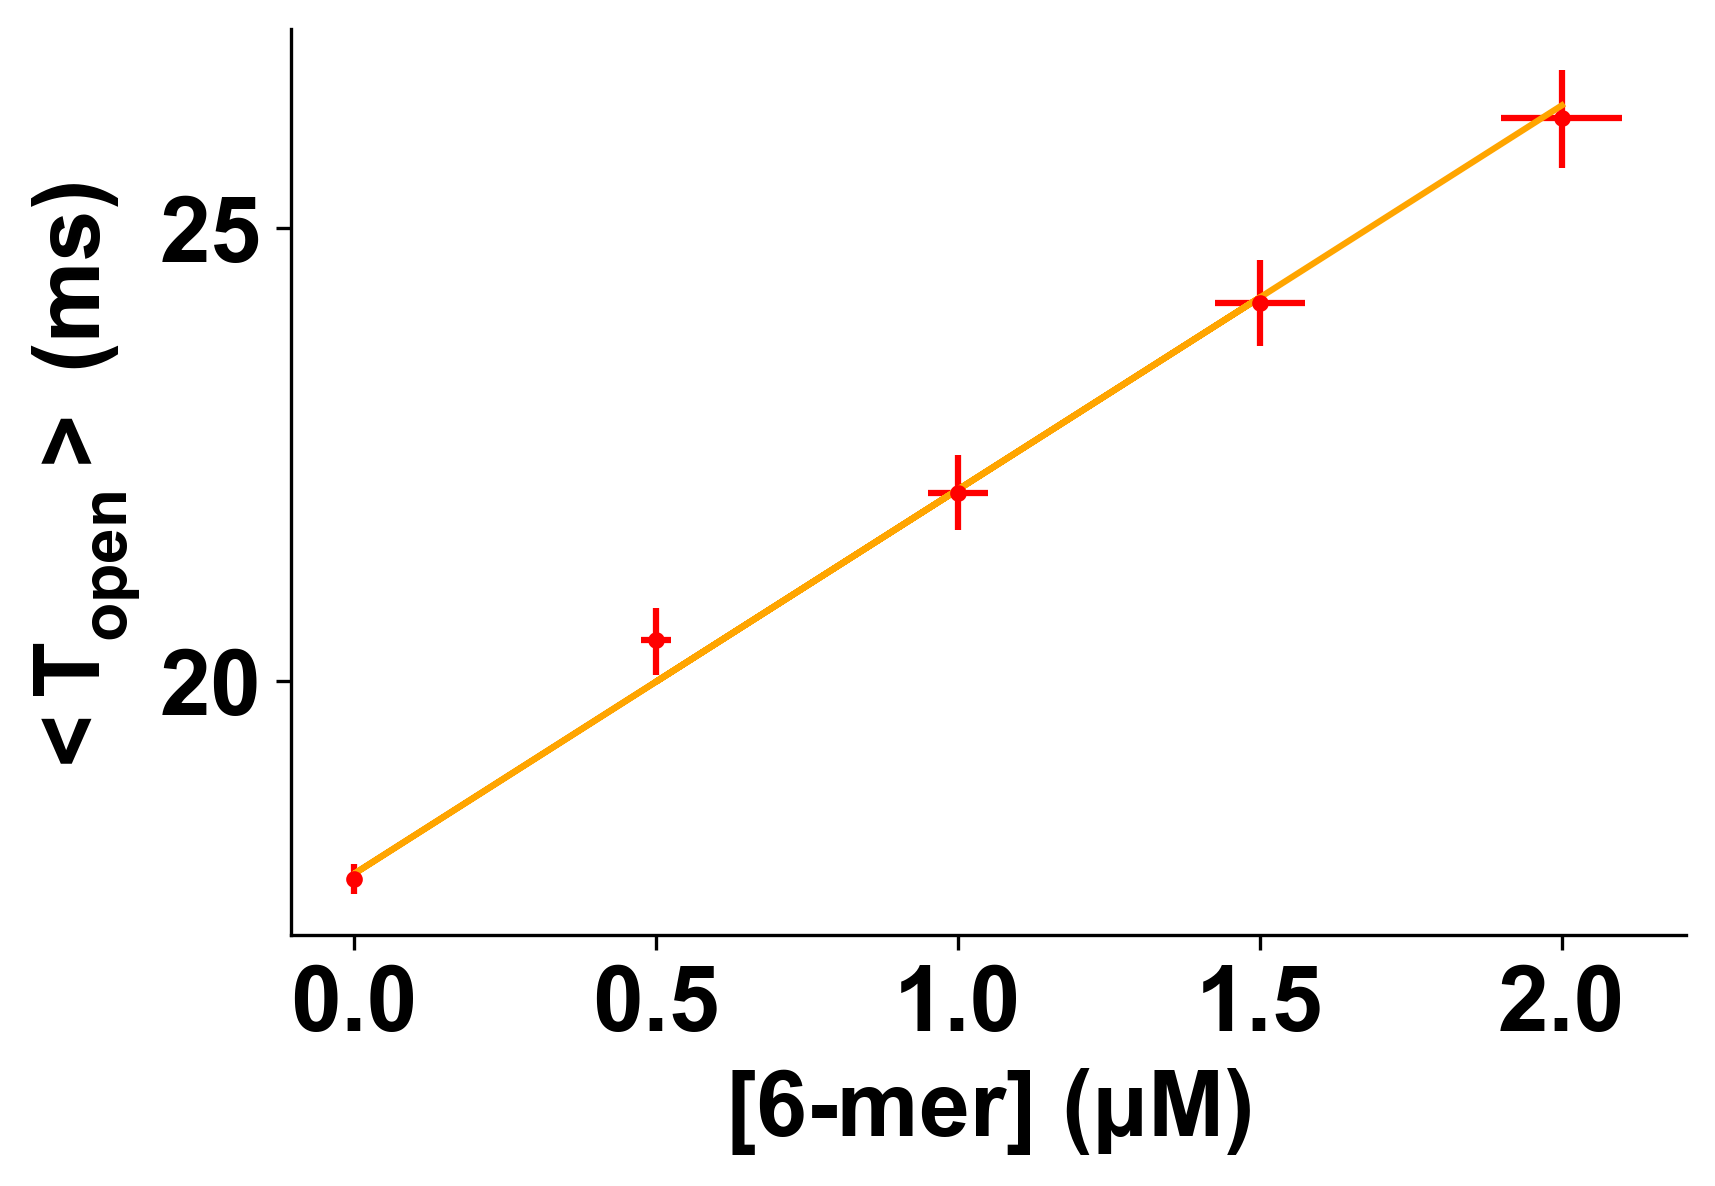

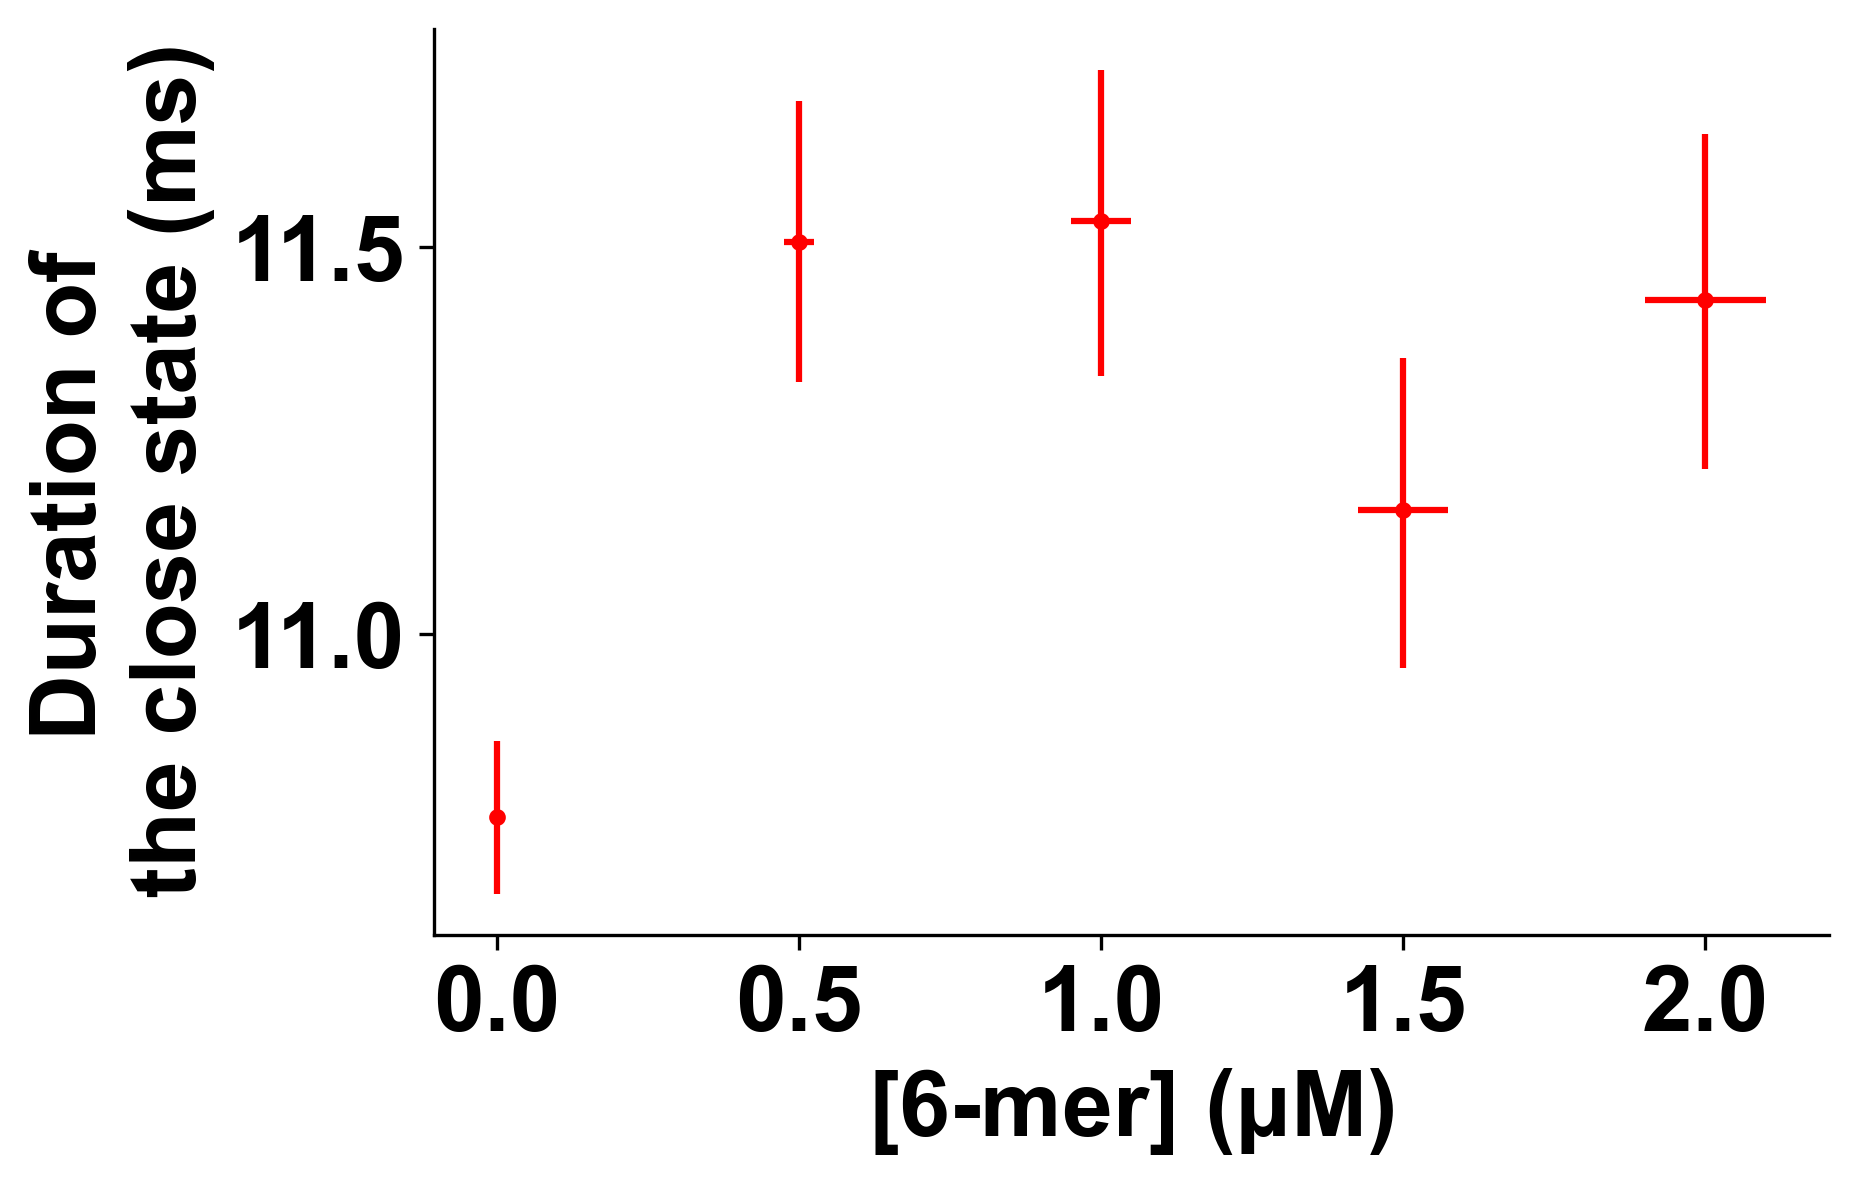

In [35]:
np.save("2020_06_18_Bd1.npy",Oliacr_2)

Oliacr_2[0][1] = 0.5
Oliacr_2[0][2] = 1.5
draw_open_state(Oliacr_2,"6-mer")
draw_close_state(Oliacr_2,"6-mer")

In [36]:
Oliacr_4 = read_dir("2020_06_22_0/")


Delta G = -7.3+- 0.11


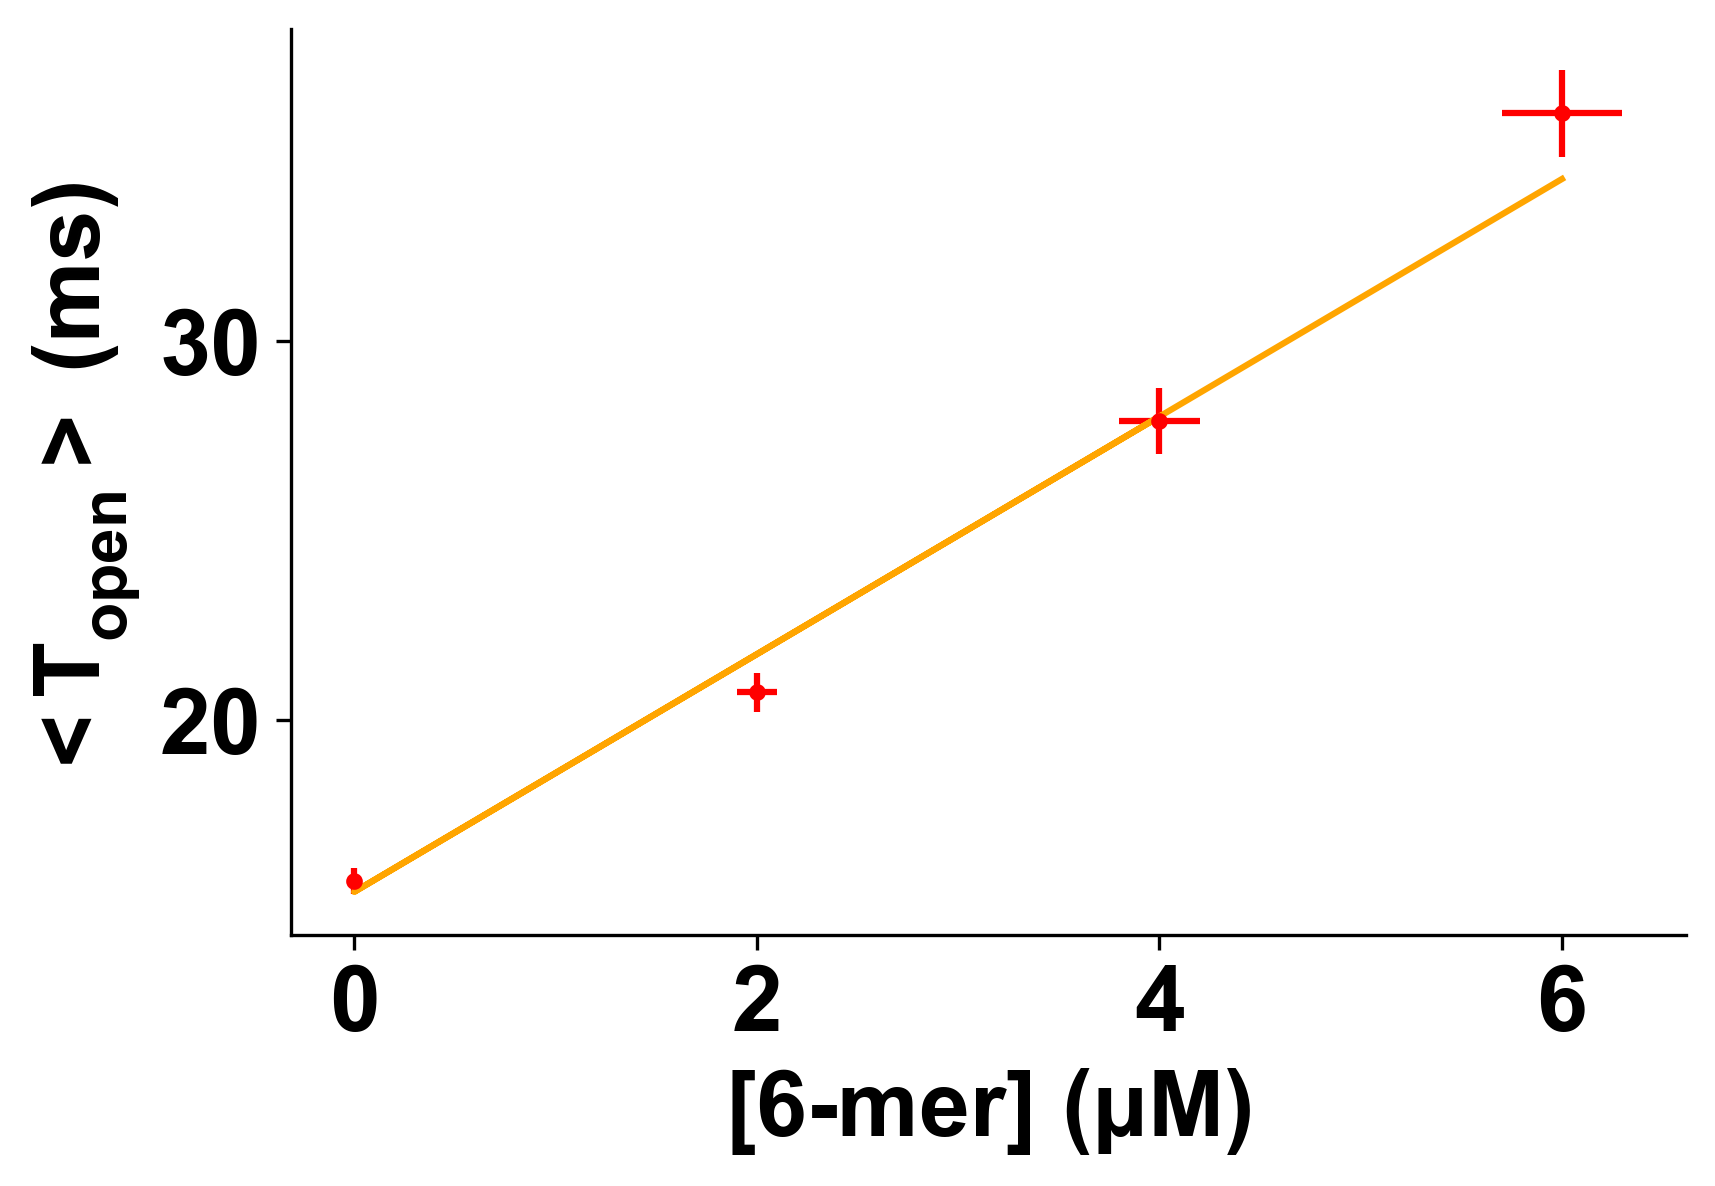

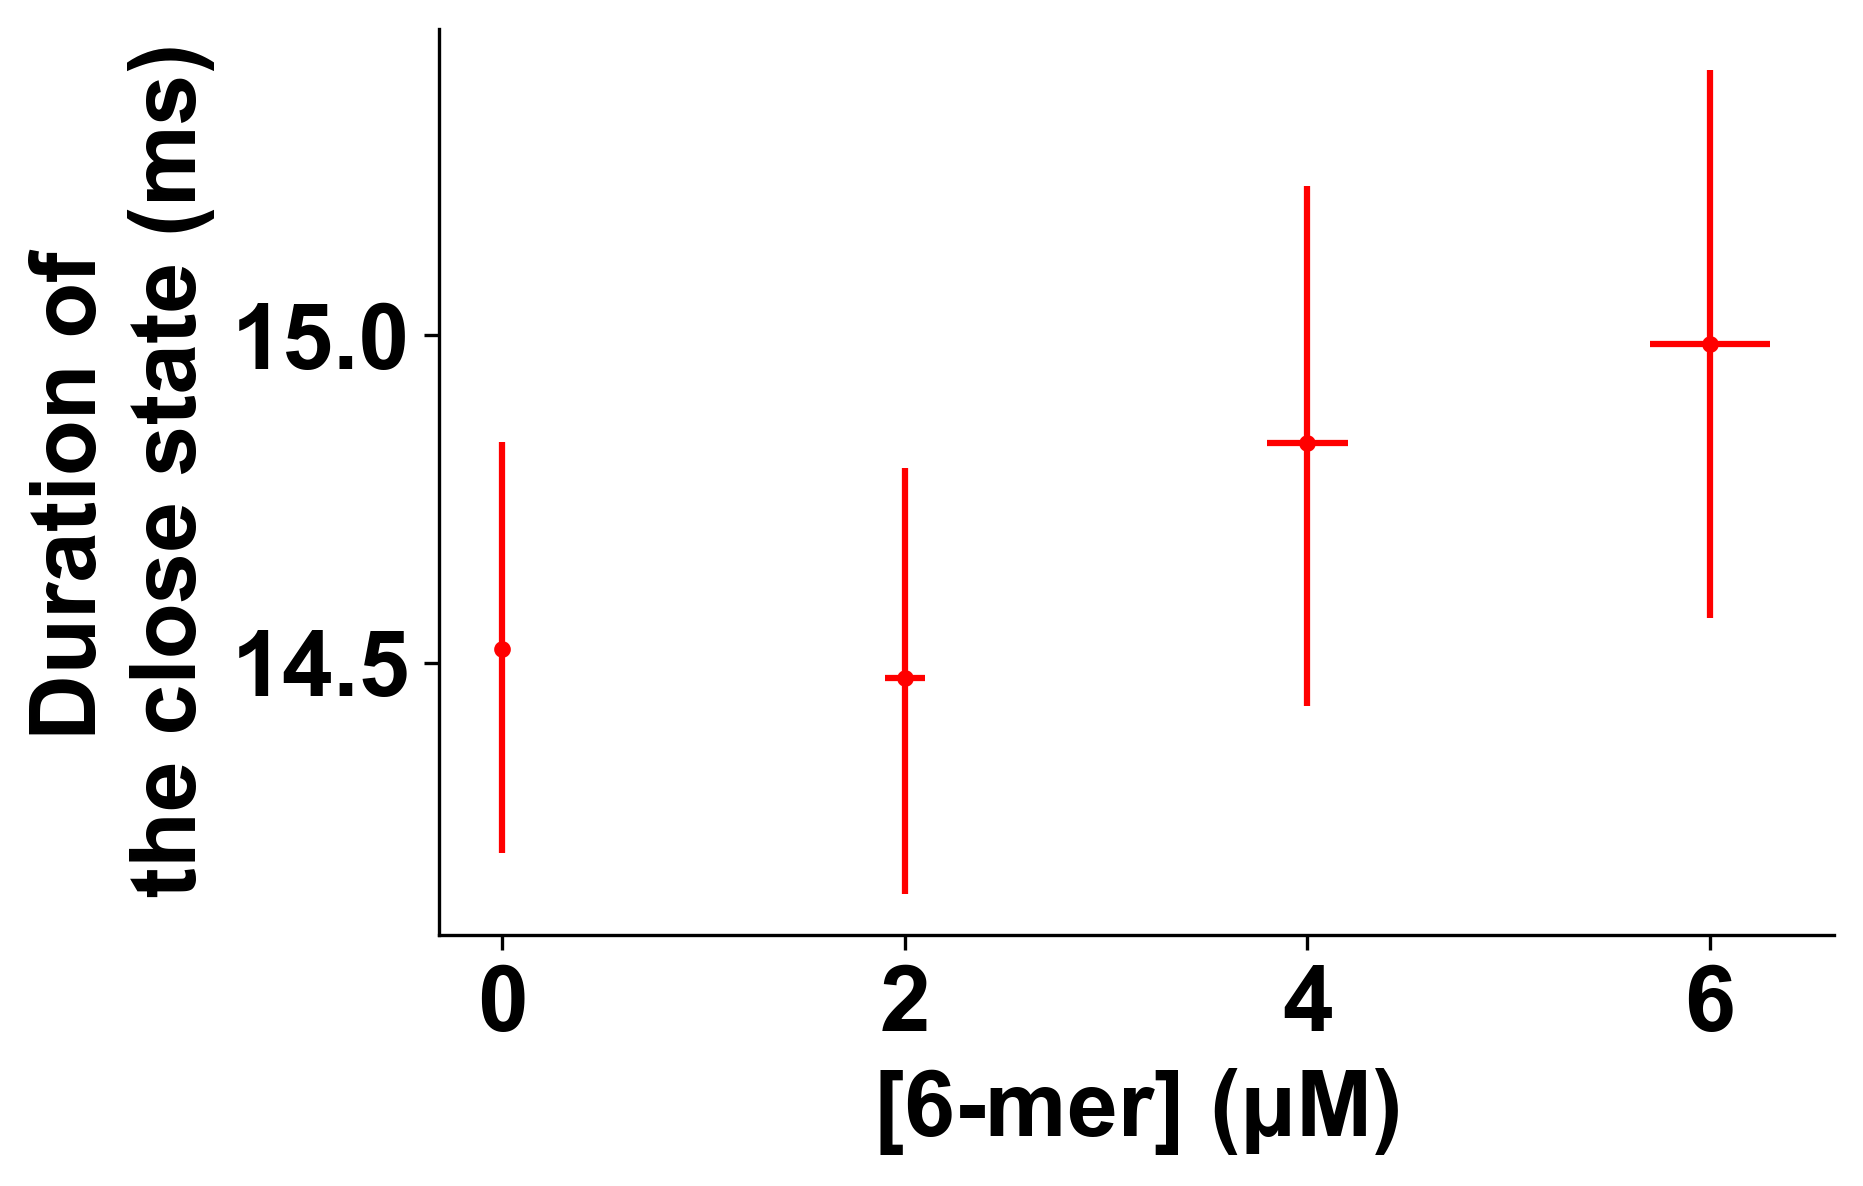

In [37]:
np.save("2020_06_22_0.npy",Oliacr_4)

draw_open_state(Oliacr_4,"6-mer")
draw_close_state(Oliacr_4,"6-mer")

Delta G = -6.0+- 0.06


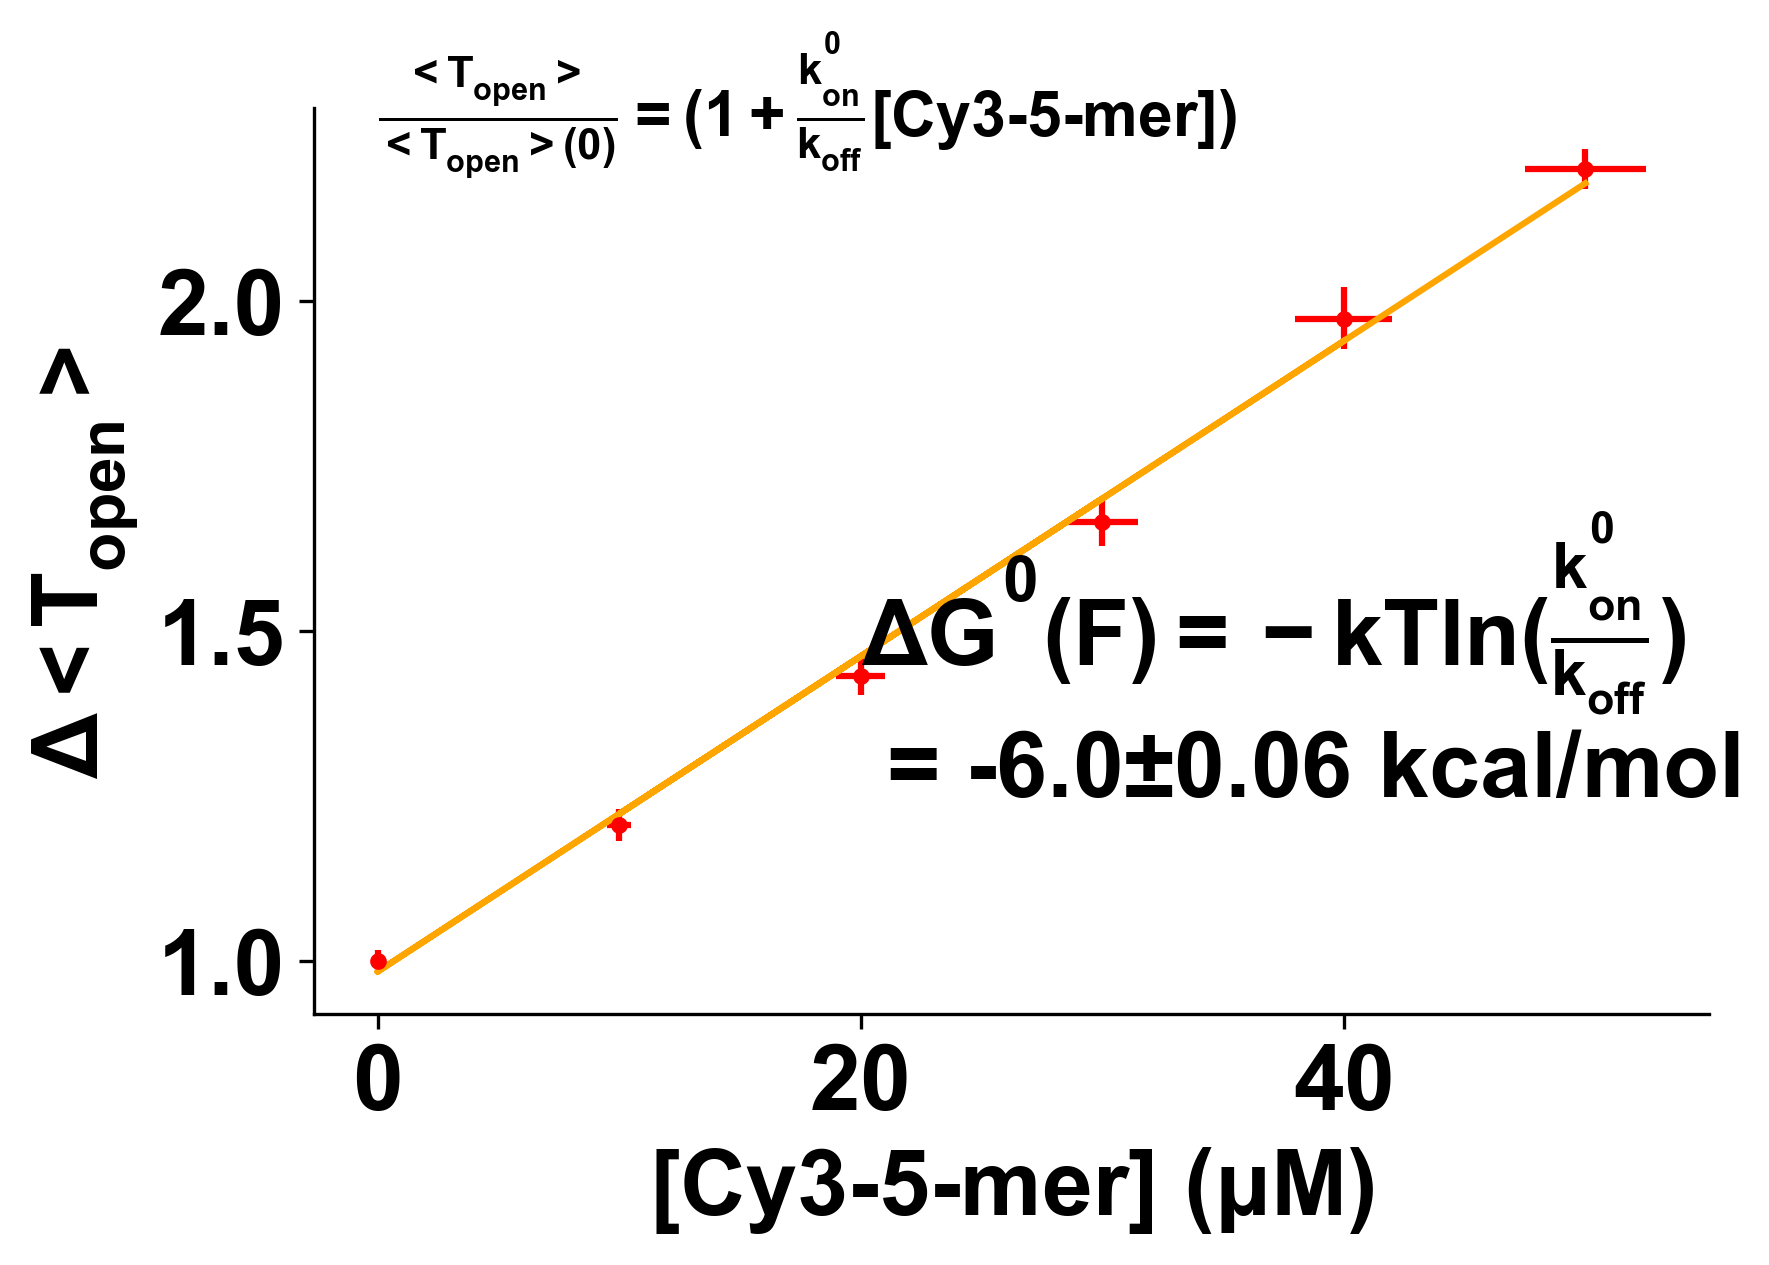

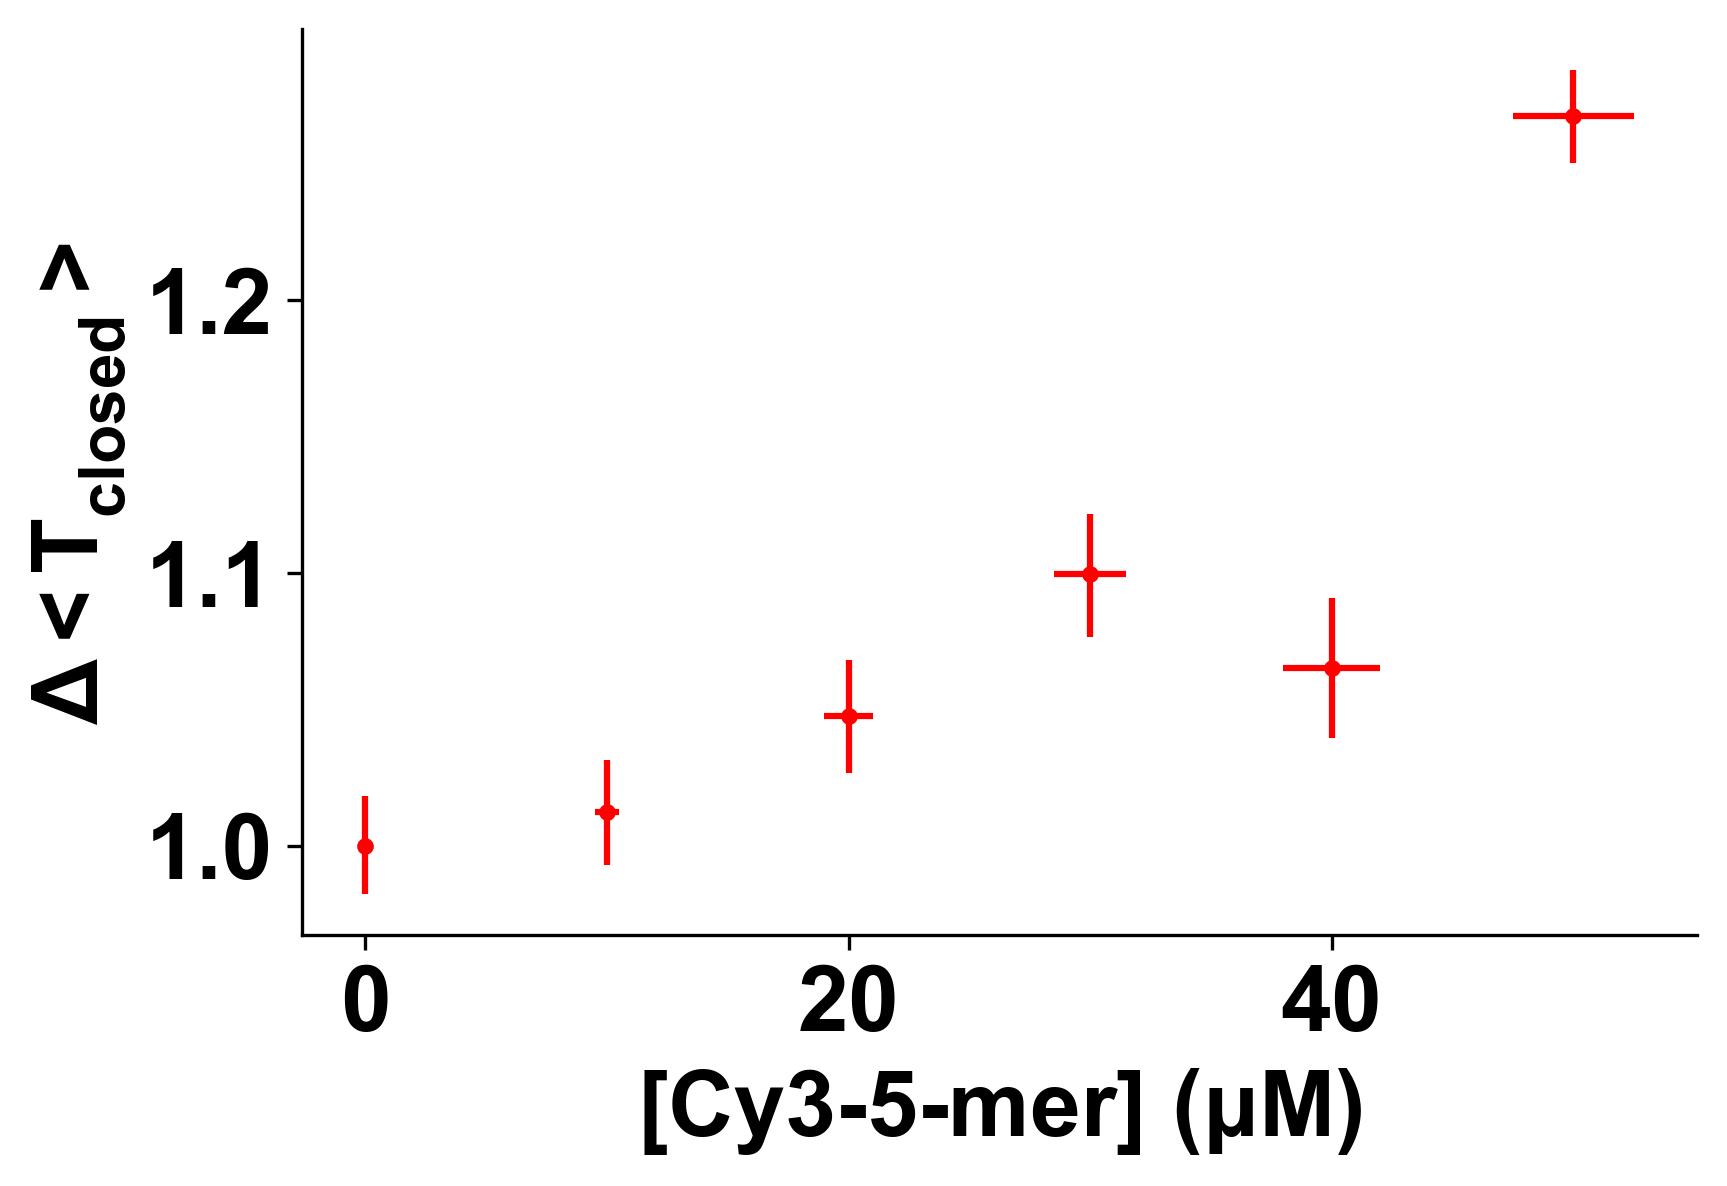

In [38]:
Olicy32 = read_dir("2020_09_12_olicy3/")
np.save("2020_09_12_olicy3.npy",Olicy32)
draw_open_state(Olicy32,"Cy3-5-mer",1,0,2.25,20,1.25)
draw_close_state(Olicy32,"Cy3-5-mer",1)

Delta G = -6.12+- 0.06


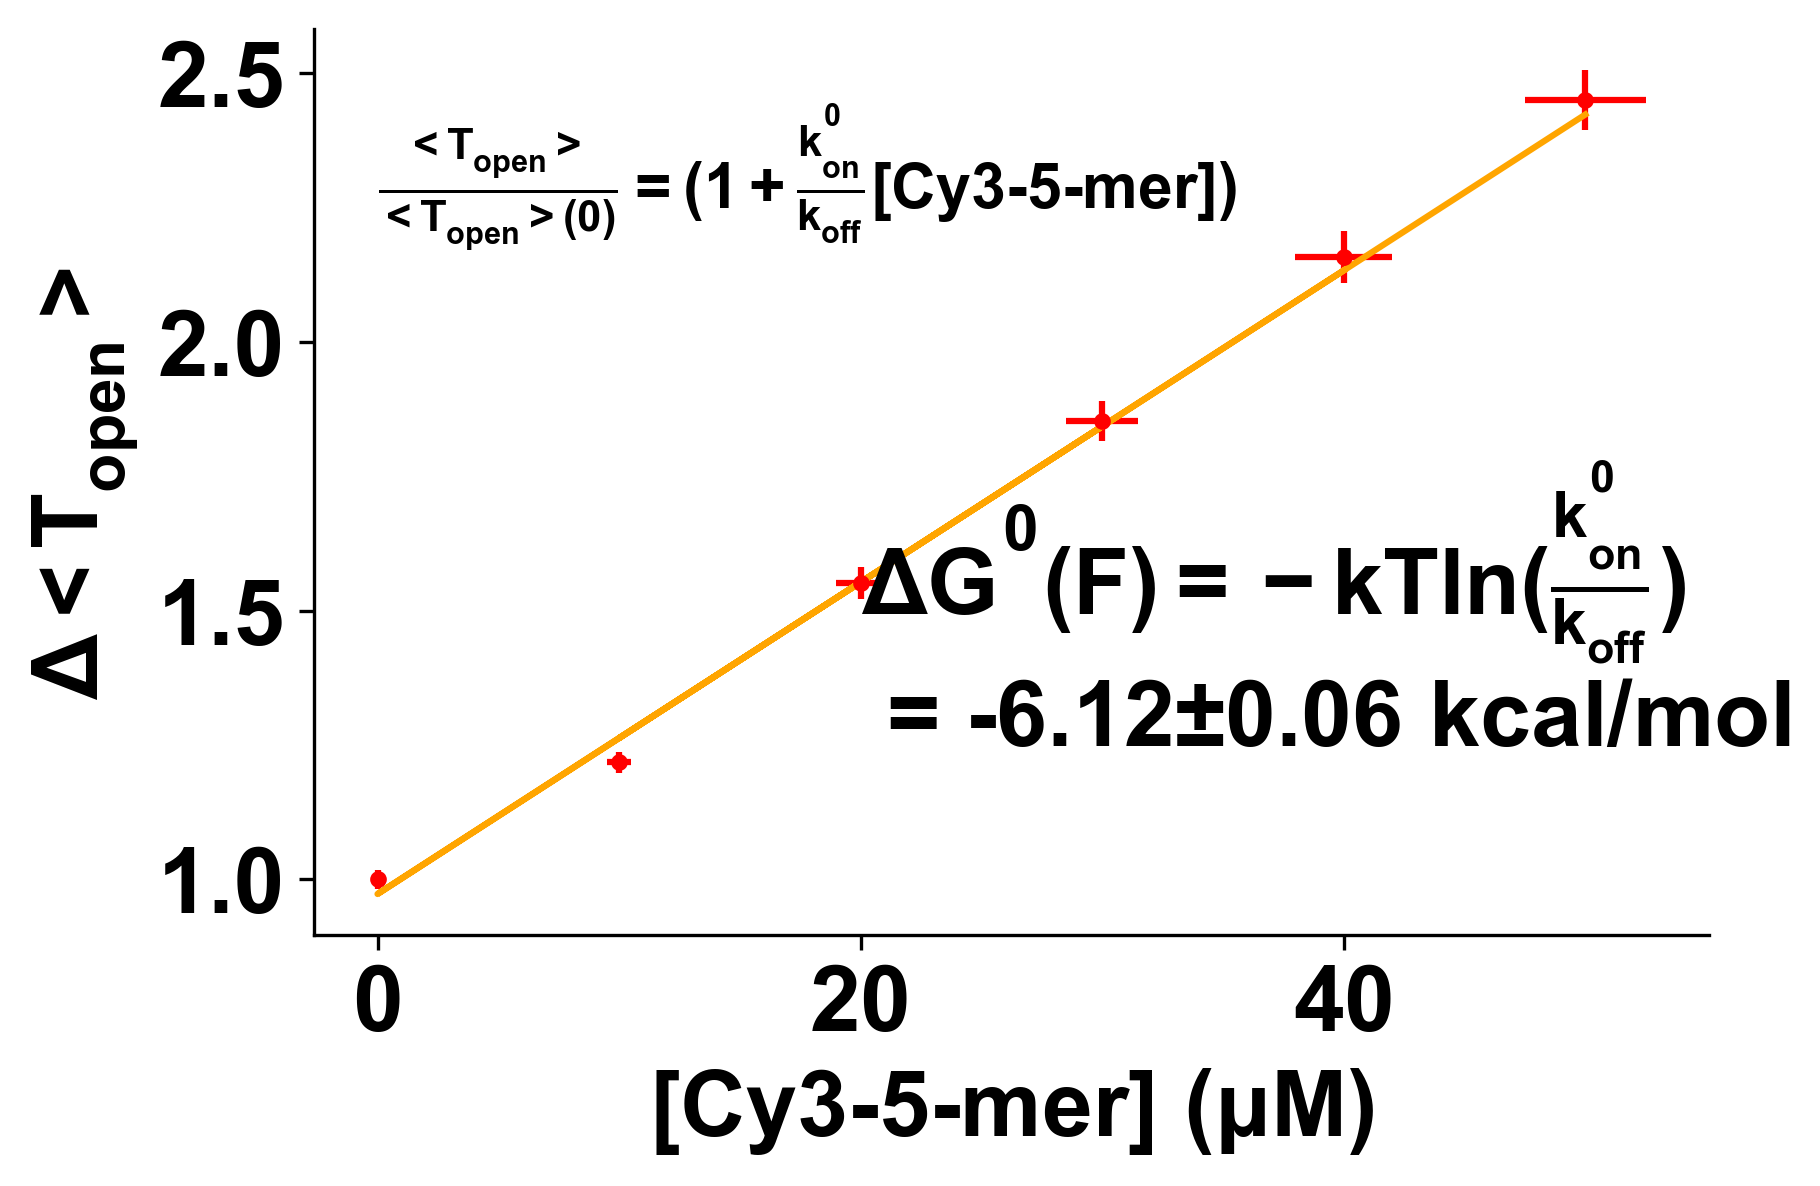

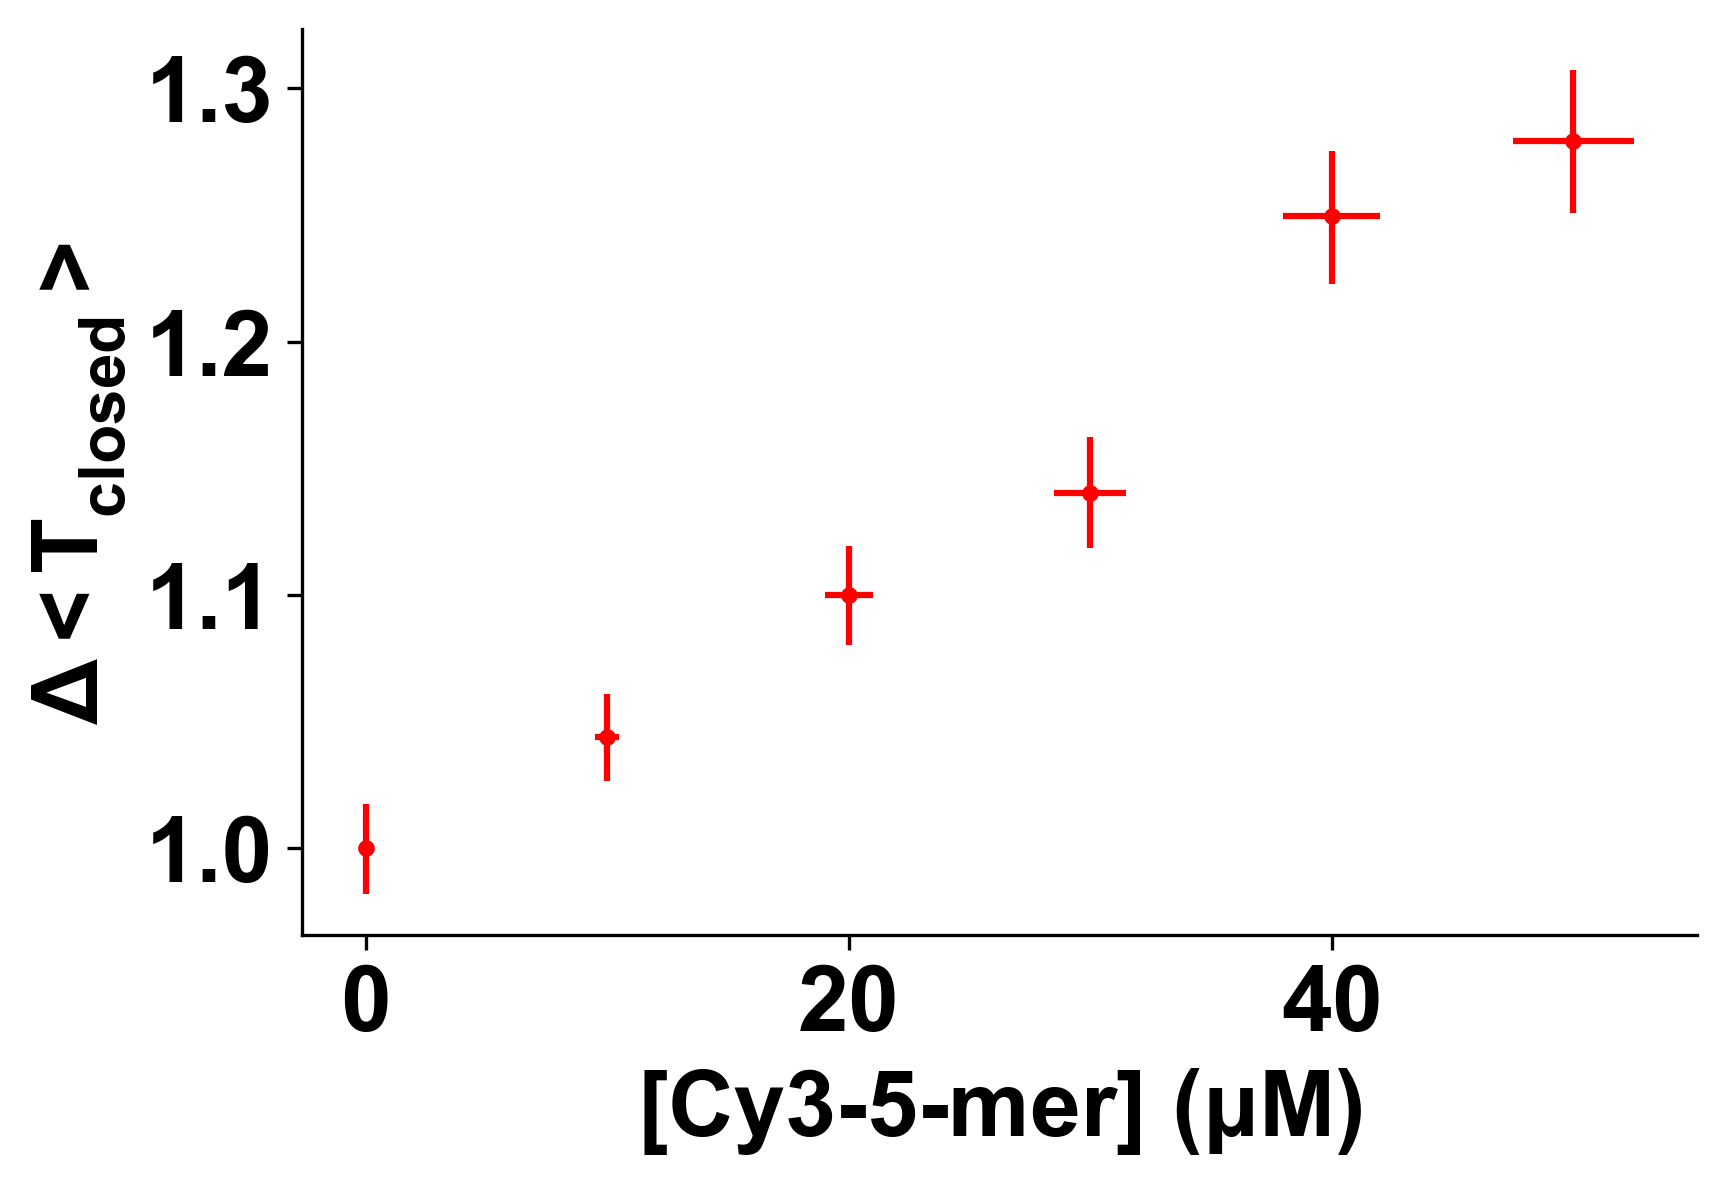

In [39]:
Olicy3 = read_dir("2020_09_02/")
np.save("2020_09_02.npy",Olicy3)
draw_open_state(Olicy3,"Cy3-5-mer",1,0,2.25,20,1.25)
draw_close_state(Olicy3,"Cy3-5-mer",1)

In [40]:
Oliacr_5 = read_dir("2020_06_22_2/")


Delta G = -7.23+- 0.06


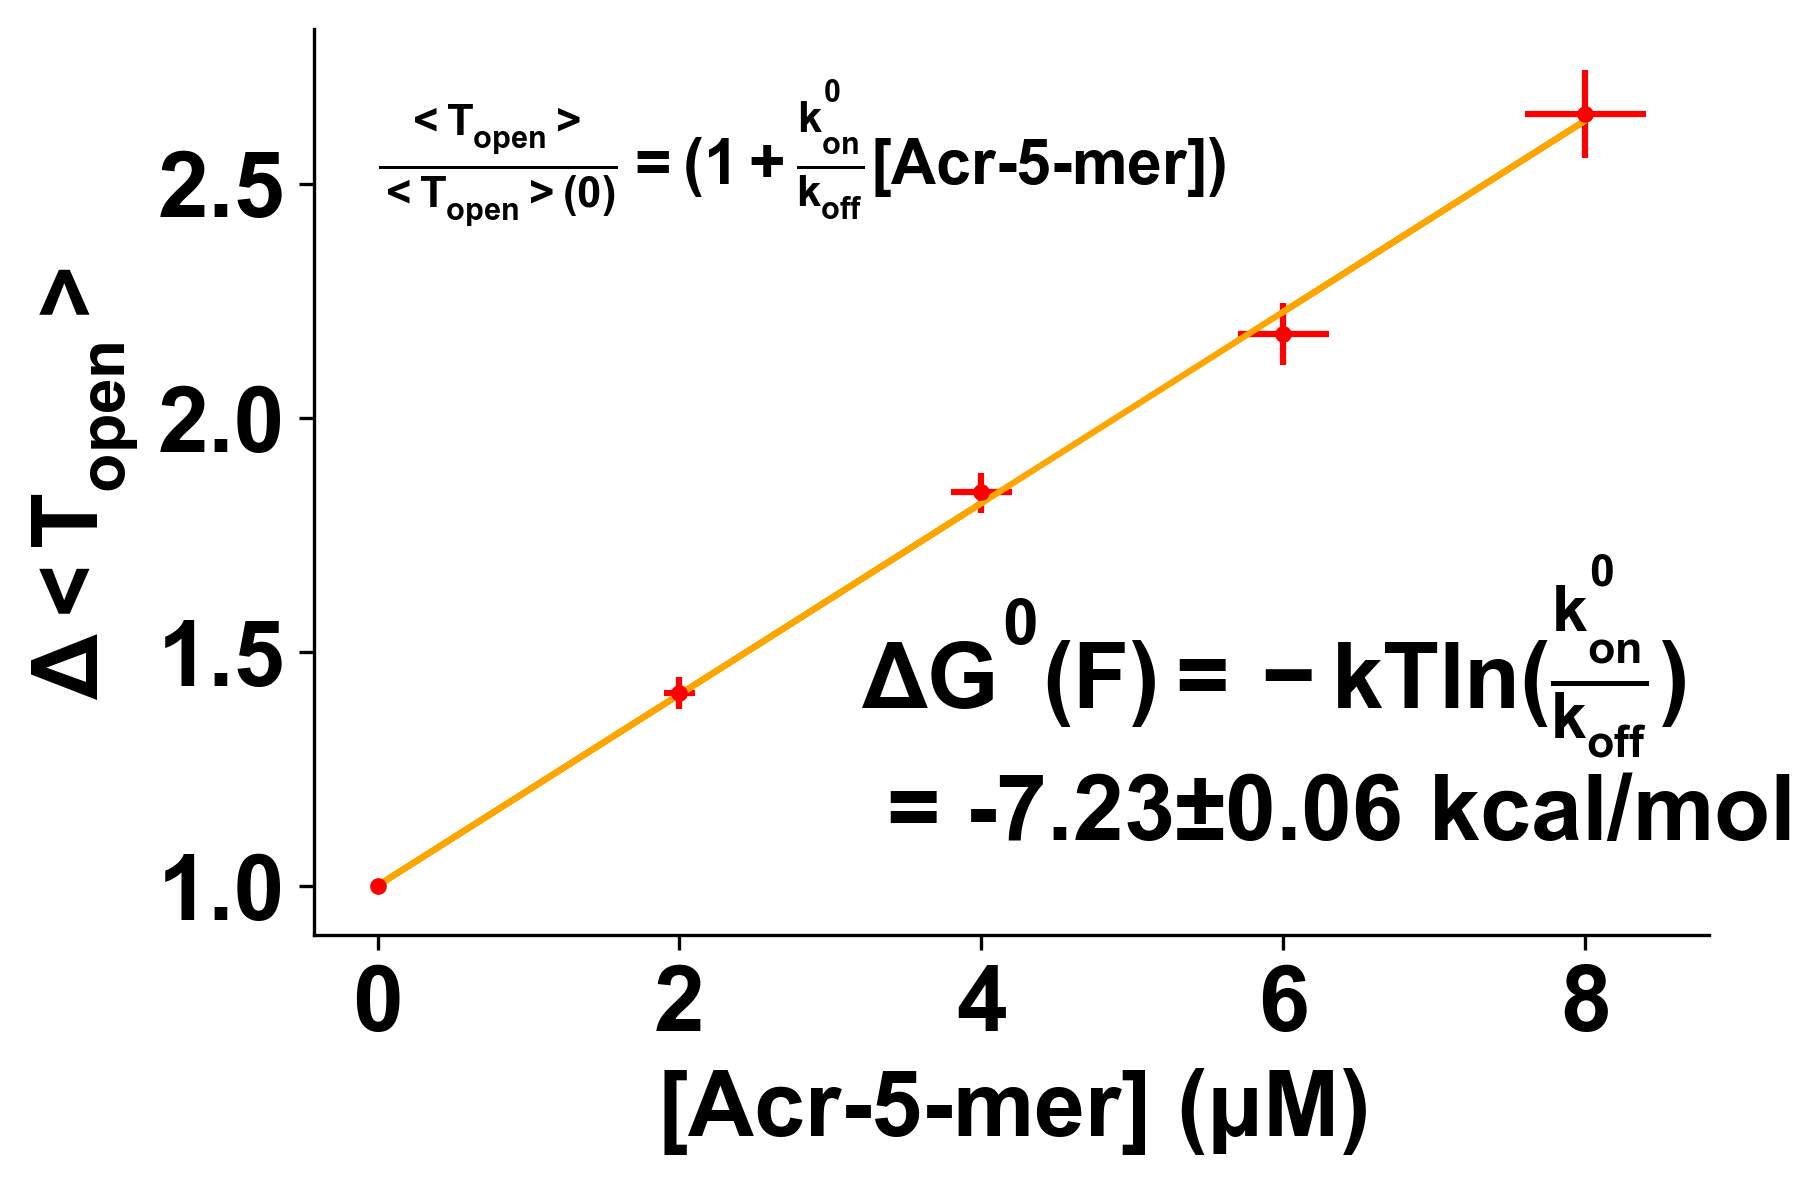

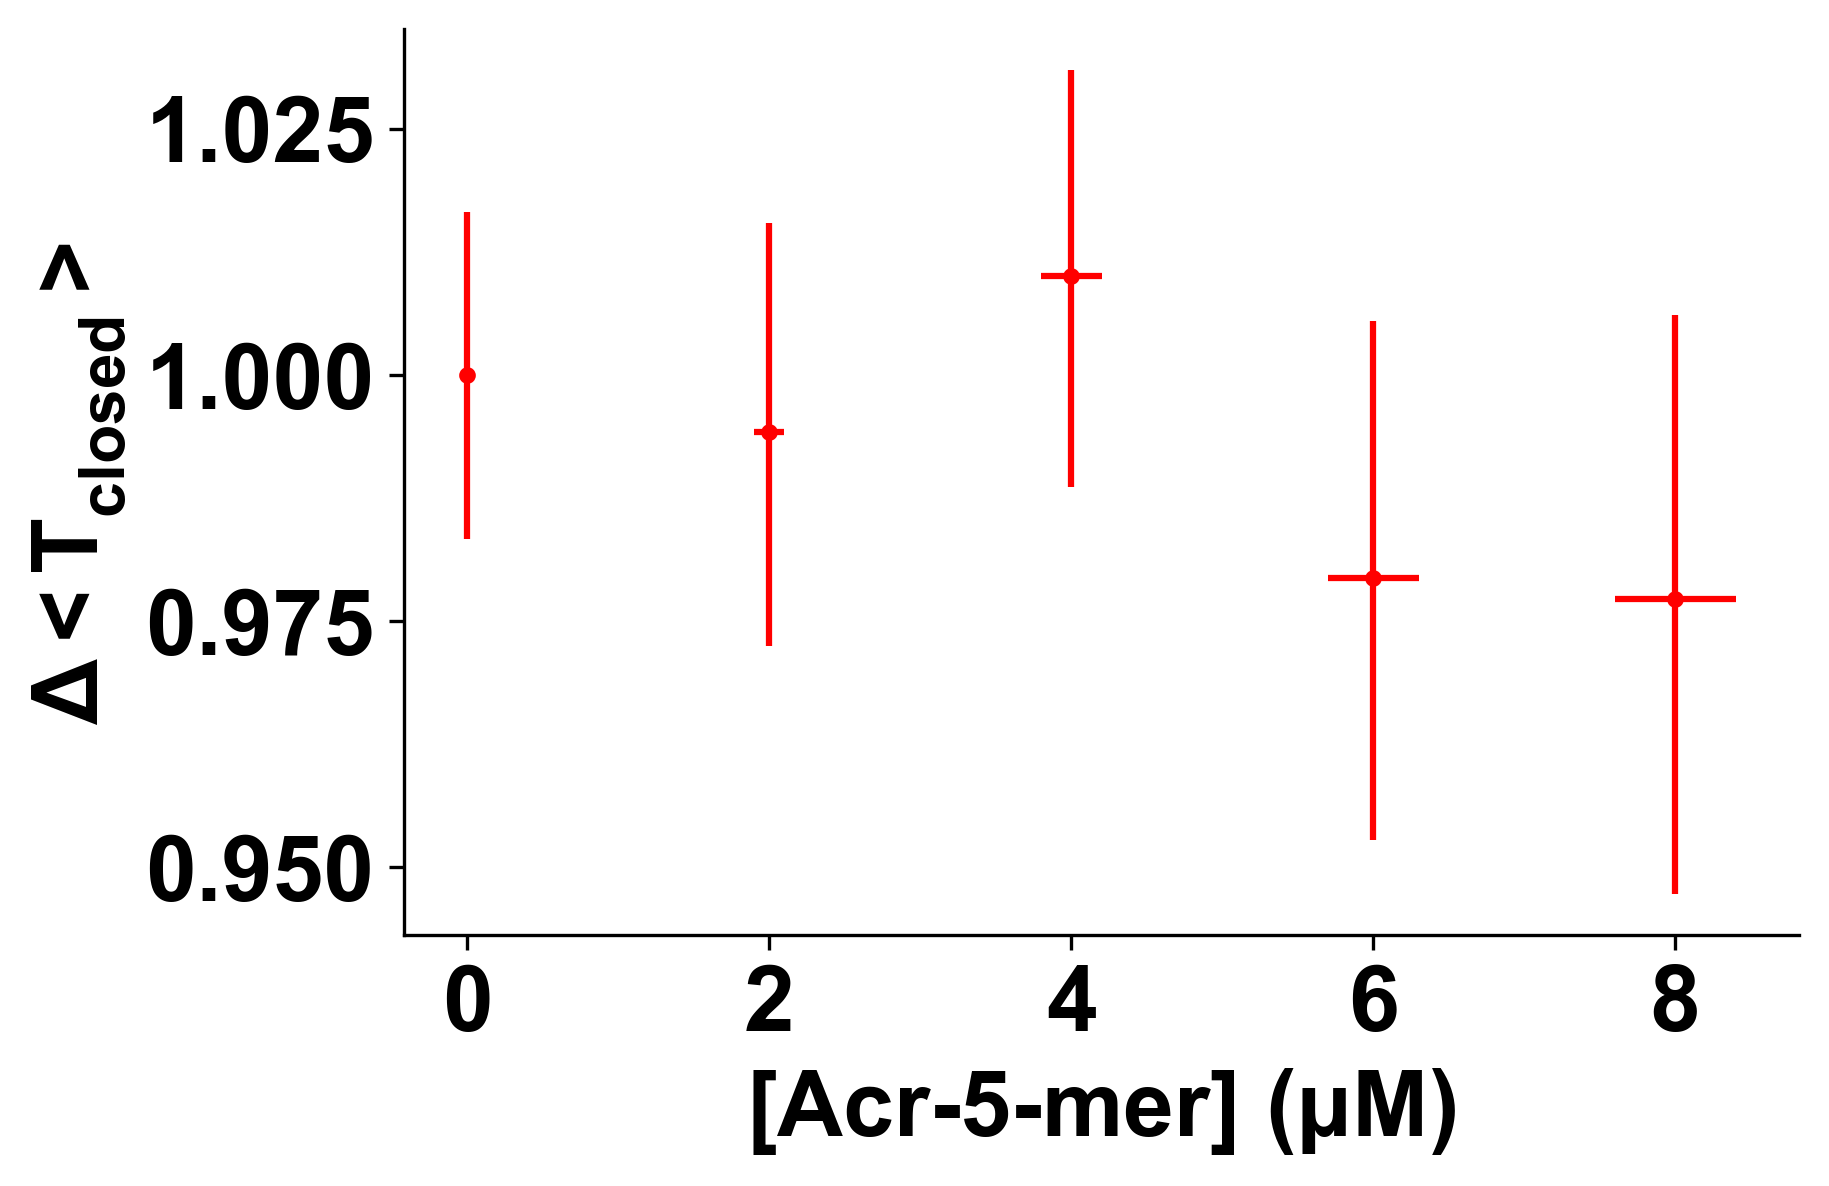

In [41]:
np.save("2020_06_22_2.npy",Oliacr_5)

draw_open_state(Oliacr_5,"Acr-5-mer",1,0,2.5,3.2,1.1)
draw_close_state(Oliacr_5,"Acr-5-mer",1)